In [256]:
#Created by Eva Baker for SPH6004 Individual Assignment  
#Still to learn: how to freeze versions of packages for better reproducability 

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector as SFS, RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier as RFC, VotingClassifier
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

#try halving gs to try to help with runtime 
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [258]:
filepath = "C:/Users/evalb/Box/Courses/SPH6004_AdvStats/MIMIC/RawData/"
filename = "sph6004_assignment1_data.csv"

print(filepath)

raw = pd.read_csv(filepath + filename)

#Expected: 162 cols and 50,920 rows
#Imported: 162 cols and 50,920 < match
print(raw.shape)

print(raw.head())


C:/Users/evalb/Box/Courses/SPH6004_AdvStats/MIMIC/RawData/
(50920, 162)
         id  aki gender  admission_age                    race  \
0  36570066    3      F      79.953141  BLACK/AFRICAN AMERICAN   
1  39307659    0      F      78.194169         WHITE - RUSSIAN   
2  38743306    2      F      65.602396                   WHITE   
3  32339865    2      F      64.906629                 UNKNOWN   
4  35526987    2      M      57.438861                   WHITE   

   heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  \
0            96.0           104.0       100.083333    103.0    126.0  ...   
1            72.0           134.0        97.263158     97.0    127.0  ...   
2            60.0            97.0        84.166667     95.0    143.0  ...   
3            59.0            87.0        71.461538    113.0    150.0  ...   
4            57.0           100.0        82.387097     81.0    127.0  ...   

   ggt_max  ld_ldh_min  ld_ldh_max  gcs_min  gcs_motor  gcs_verbal  

In [259]:
#convert id to string so it isn't subject to outlier removal or anything 
raw["id"] = raw["id"].astype(str)
raw["gcs_unable"] = raw["gcs_unable"].astype(str)

#fix to cleaner 1/0 instead of 1.0/0.0
    #so few unable, flip to 0 (equivalent to 'most_frequent' treatment in sklearn SimpleImputer
raw["gcs_unable"] = ['1' if x == '1.0' else 0 for x in raw["gcs_unable"]]
print(raw["gcs_unable"].value_counts())

0    40497
1    10423
Name: gcs_unable, dtype: int64


In [260]:
#only two char columns - expected plus ones I added
print(raw.select_dtypes("object"))

             id gender                    race gcs_unable
0      36570066      F  BLACK/AFRICAN AMERICAN          0
1      39307659      F         WHITE - RUSSIAN          0
2      38743306      F                   WHITE          0
3      32339865      F                 UNKNOWN          1
4      35526987      M                   WHITE          1
...         ...    ...                     ...        ...
50915  33431859      M                   WHITE          0
50916  38881410      F                   WHITE          1
50917  31061555      F                   WHITE          0
50918  32355547      F              PORTUGUESE          0
50919  38115934      M                 UNKNOWN          1

[50920 rows x 4 columns]


0    0.331108
2    0.319874
1    0.193205
3    0.155813
Name: aki, dtype: float64


<Axes: xlabel='aki', ylabel='count'>

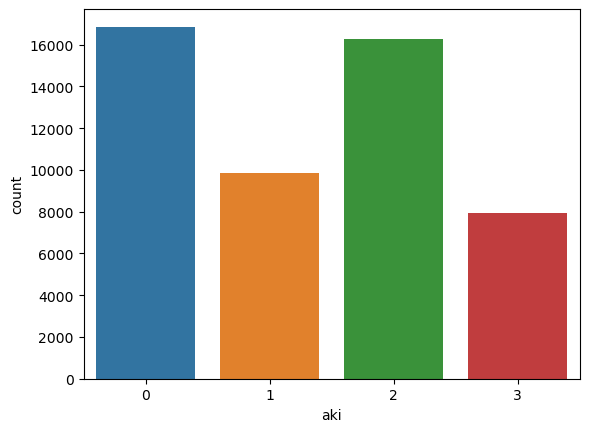

In [261]:
#decide if need to stratify or not based on outcome var

print(raw["aki"].value_counts(normalize=True, sort=True))

sns.countplot(data=raw, x="aki")


In [262]:
#raw["aki_severe"] = np.where(raw["aki"]>=2,1,0)
raw["aki_severe"] = [1 if x >= 2 else 0 for x in raw["aki"]]

print(pd.crosstab(raw["aki"], raw["aki_severe"]))

print(pd.crosstab(raw["aki"], raw["aki_severe"], normalize=True))

print(raw["aki_severe"].value_counts(normalize=True))

aki_severe      0      1
aki                     
0           16860      0
1            9838      0
2               0  16288
3               0   7934
aki_severe         0         1
aki                           
0           0.331108  0.000000
1           0.193205  0.000000
2           0.000000  0.319874
3           0.000000  0.155813
0    0.524313
1    0.475687
Name: aki_severe, dtype: float64


In [263]:
raw["aki_severe_char"] = ['Y' if x == 1 else 'N' for x in raw["aki_severe"]]

print(pd.crosstab(raw["aki_severe"], raw["aki_severe_char"], normalize=True))

aki_severe_char         N         Y
aki_severe                         
0                0.524313  0.000000
1                0.000000  0.475687


In [264]:
#drop original AKI to avoid it going into feature selection and such
raw = raw.drop(columns=["aki"])

### Additional Feature Creation ###

In [265]:
#create these now, but don't check association until I can look at training data only (don't want to peak into external validation data)
#based on googling the lab values: 
raw["lactate_max_GT2"] = [1 if x > 2.0 else 0 for x in raw["lactate_max"]]
raw["lactate_max_GT4"] = [1 if x > 5.0 else 0 for x in raw["lactate_max"]]

#https://www.mountsinai.org/health-library/tests/creatine-phosphokinase-test
raw["ck_cpk_max_GT120"] = [1 if x > 120 else 0 for x in raw["ck_cpk_max"]]

#Per KDIGO, one way to diagnose AKI is very low urine output (oliguria), so perhaps missing a urine measurement is meaningful for us 
raw["ph_min_missing"] = [0 if x >= 0 else 1 for x in raw["ph_min"]]

#later, if time:
    #calc bmi >> impute BMI  -- probably too highly correlated with weight? esp since height is heavily missing (51%) and would be heavily imputed 

### Drop poorly populated columns ### 

In [266]:
#stats for vars with over x% fill rate
missing_threshold = len(raw)*0.40
print(f"missing threshold: {missing_threshold}")

cols_over_threshold = raw.columns[raw.isna().sum() <= missing_threshold]

print(f"cols over threshold: {len(cols_over_threshold)}")

missing threshold: 20368.0
cols over threshold: 90


In [267]:
print(raw.shape)

raw = raw[cols_over_threshold]

print(raw.shape)

(50920, 167)
(50920, 90)


### Remove test and validation data to avoid gaining insights on it during exploration ###

per: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 
have y split out first
then just add more dfs coming out of the split



In [268]:
print(raw.columns)

Index(['id', 'gender', 'admission_age', 'race', 'heart_rate_min',
       'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean',
       'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean',
       'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min',
       'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max',
       'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'ph_min',
       'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max',
       'baseexcess_min', 'baseexcess_max', 'totalco2_min', 'totalco2_max',
       'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1',
       'hemoglobin_max.1', 'platelets_min', 'platelets_max', 'wbc_min',
       'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1',
       'bicarbonate_max.1', 'bun_min', 'bun_max', 'calcium_min.1',
       'calcium_max.1', 'chloride_min.1', 'chloride_max.1', 'glucose_min.2',
       'glucose_max.2', 'sodium_min.1', 'sodium_max.1', 'potassiu

#### Create new vars before the split #### 
#note: these were created after analyzing ONLY train data



In [269]:
#race 
'''

#create list of categories
race_categories = ["AMERICAN INDIAN/ALASKA NATIVE/PACIFIC ISLANDER", "ASIAN", "BLACK/AFRICAN AMERICAN", "HISPANIC/LATINO", 
"MULTIPLE", "WHITE"]

#associated raw values
amer_indian = "AMERICAN INDIAN/ALASKA NATIVE|NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER"
asian = "ASIAN"
black_aa = "BLACK/AFRICAN|BLACK/AFRICAN AMERICAN|BLACK/CAPE VERDEAN|BLACK/CARIBBEAN ISLAND"
hisp = "HISPANIC OR LATINO|HISPANIC/LATINO|SOUTH AMERICAN" 
mult = "MULTIPLE RACE/ETHNICITY"
white = "WHITE"


conditions = [
    (raw["race"].str.contains(amer_indian)),
    (raw["race"].str.contains(asian)),
    (raw["race"].str.contains(black_aa)),
    (raw["race"].str.contains(hisp)),
    (raw["race"].str.contains(mult)),
    (raw["race"].str.contains(white))    
]


#apply
original: raw["race_clean"] = np.select(conditions, race_categories, default="UNKNOWN/OTHER")
'''

'\n\n#create list of categories\nrace_categories = ["AMERICAN INDIAN/ALASKA NATIVE/PACIFIC ISLANDER", "ASIAN", "BLACK/AFRICAN AMERICAN", "HISPANIC/LATINO", \n"MULTIPLE", "WHITE"]\n\n#associated raw values\namer_indian = "AMERICAN INDIAN/ALASKA NATIVE|NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER"\nasian = "ASIAN"\nblack_aa = "BLACK/AFRICAN|BLACK/AFRICAN AMERICAN|BLACK/CAPE VERDEAN|BLACK/CARIBBEAN ISLAND"\nhisp = "HISPANIC OR LATINO|HISPANIC/LATINO|SOUTH AMERICAN" \nmult = "MULTIPLE RACE/ETHNICITY"\nwhite = "WHITE"\n\n\nconditions = [\n    (raw["race"].str.contains(amer_indian)),\n    (raw["race"].str.contains(asian)),\n    (raw["race"].str.contains(black_aa)),\n    (raw["race"].str.contains(hisp)),\n    (raw["race"].str.contains(mult)),\n    (raw["race"].str.contains(white))    \n]\n\n\n#apply\noriginal: raw["race_clean"] = np.select(conditions, race_categories, default="UNKNOWN/OTHER")\n'

In [270]:
#race 

#create list of categories
race_categories = ["BLACK_AA"]

#associated raw values
black_aa = "BLACK/AFRICAN|BLACK/AFRICAN AMERICAN|BLACK/CAPE VERDEAN|BLACK/CARIBBEAN ISLAND"

conditions = [
    (raw["race"].str.contains(black_aa))
]


#apply
raw["race_clean"] = np.select(conditions, race_categories, default="NON_BLACK_AA")


In [271]:
#looks good: pd.crosstab(raw["race"], raw["race_clean"])


In [272]:
#Seems like masking may have been imperfect, which is also common
    #see Qian page 626 – set any over >89 equal to 90 
    
raw["age_clean"] = [90 if x > 89 else x for x in raw["admission_age"]]

#drop original so it doesn't go through feature selection
raw = raw.drop(columns=["admission_age"])


#### Prep categorical vars ####

In [273]:
#drop_first=True will give us our reference class: 
    #male 
    #race_clean_NON_BLACK_AA

raw = pd.get_dummies(data=raw, columns=["gender", "race_clean", "gcs_unable"], drop_first=True)

print(raw.columns)

Index(['id', 'race', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1',
       'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max',
       'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1',
       'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1',
       'potassium_min.1', 'potassium_max.1'

In [274]:
#split into x and y

xraw = raw.drop(columns=["aki_severe"])
print(xraw.shape)

yraw = raw["aki_severe"]
print(yraw.shape)
print(yraw)

(50920, 90)
(50920,)
0        1
1        0
2        1
3        1
4        1
        ..
50915    0
50916    1
50917    0
50918    1
50919    1
Name: aki_severe, Length: 50920, dtype: int64


### Train-Test-Validate Split ###

In [275]:
x_train, x_test_temp, y_train, y_test_temp = train_test_split(
    xraw, yraw
    , train_size = 0.7, test_size = 0.3
    , random_state = 123 #seed
    , shuffle = True
)

#note: unlike numpy random method, these are exactly at 70-30-30 split
print(x_train.shape)
print(y_train.shape)

print(x_test_temp.shape)
print(y_test_temp.shape)


#split into test and validate
x_test, x_validate, y_test, y_validate = train_test_split(
    x_test_temp, y_test_temp
    ,train_size = 0.5, test_size=0.5
    ,random_state=123 #seed
    ,shuffle=True #shuffle before splitting
)

print(x_test.shape)
print(y_test.shape)

print(x_validate.shape)
print(y_validate.shape)


(35644, 90)
(35644,)
(15276, 90)
(15276,)
(7638, 90)
(7638,)
(7638, 90)
(7638,)


In [276]:
train = pd.concat([x_train,y_train],axis=1)

print(train.columns)

Index(['id', 'race', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1',
       'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max',
       'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1',
       'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1',
       'potassium_min.1', 'potassium_max.1'

In [277]:
#checks:
pd.crosstab(train["gender_M"], train["race_clean_NON_BLACK_AA"])

race_clean_NON_BLACK_AA,0,1
gender_M,,
0,1772,13922
1,1525,18425


0    0.524745
1    0.475255
Name: aki_severe, dtype: float64


<Axes: xlabel='aki_severe', ylabel='count'>

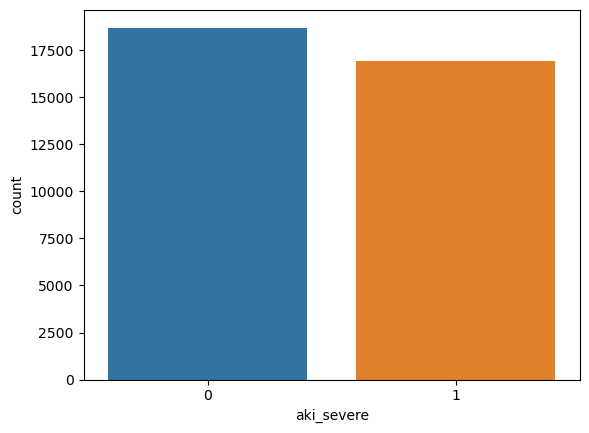

In [278]:
#work off on x_train now unless I need both vars

print(train["aki_severe"].value_counts(normalize=True, sort=True))

sns.countplot(data=train, x="aki_severe")


In [279]:
#mix of highly populated and highly non-populated
print(x_train.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35644 entries, 12887 to 15725
Data columns (total 90 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       35644 non-null  object 
 1   race                     35644 non-null  object 
 2   heart_rate_min           35590 non-null  float64
 3   heart_rate_max           35590 non-null  float64
 4   heart_rate_mean          35590 non-null  float64
 5   sbp_min                  35578 non-null  float64
 6   sbp_max                  35578 non-null  float64
 7   sbp_mean                 35578 non-null  float64
 8   dbp_min                  35578 non-null  float64
 9   dbp_max                  35578 non-null  float64
 10  dbp_mean                 35578 non-null  float64
 11  mbp_min                  35568 non-null  float64
 12  mbp_max                  35568 non-null  float64
 13  mbp_mean                 35568 non-null  float64
 14  resp_rate_min     

In [280]:
#males are more common and higher rate of severe aki
pd.crosstab(train["gender_M"], train["aki_severe"], normalize=True)

aki_severe,0,1
gender_M,,
0,0.234822,0.205476
1,0.289923,0.269779


In [281]:
#Age is probably truncated after a certain point, which is common as part of deid 
#pd.DataFrame.hist(train[['admission_age']])


array([[<Axes: title={'center': 'age_clean'}>]], dtype=object)

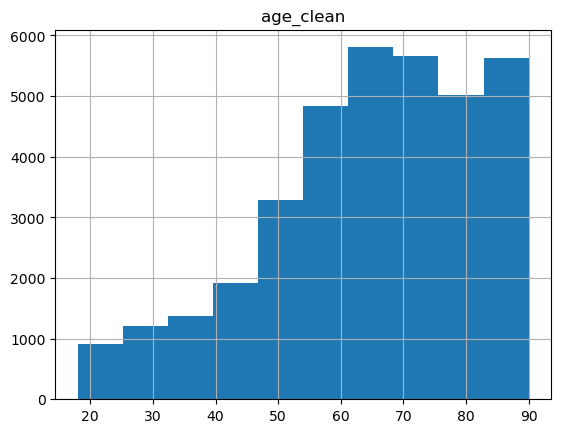

In [282]:
pd.DataFrame.hist(train[['age_clean']])

<Axes: >

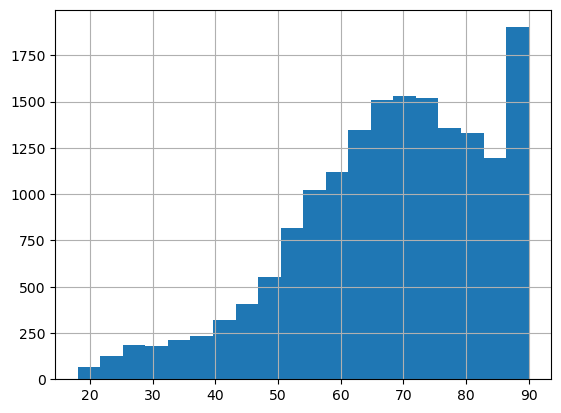

In [283]:
#expecting to see advanced age associated with higher rate of severe aki - confirmed
train[train["aki_severe"]==1]["age_clean"].hist(bins=20)

<Axes: >

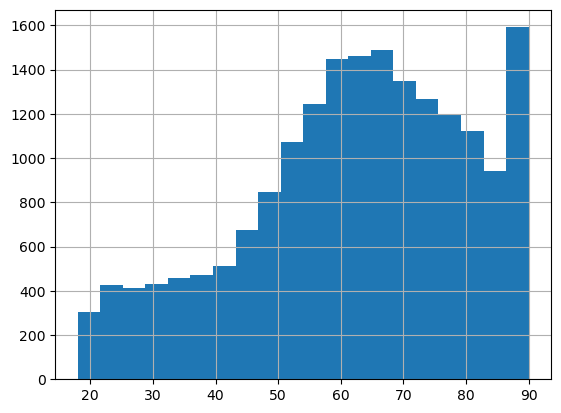

In [284]:
train[train["aki_severe"]==0]["age_clean"].hist(bins=20)

In [285]:
print(train.columns)

Index(['id', 'race', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1',
       'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max',
       'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1',
       'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1',
       'potassium_min.1', 'potassium_max.1'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35644 entries, 12887 to 15725
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_clean                35644 non-null  float64
 1   sbp_min                  35578 non-null  float64
 2   spo2_mean                35561 non-null  float64
 3   glucose_max              34814 non-null  float64
 4   hemoglobin_min.1         35303 non-null  float64
 5   hemoglobin_max.1         35303 non-null  float64
 6   platelets_min            35306 non-null  float64
 7   bicarbonate_min.1        35209 non-null  float64
 8   bun_max                  35352 non-null  float64
 9   calcium_min.1            32198 non-null  float64
 10  calcium_max.1            32198 non-null  float64
 11  potassium_max.1          35196 non-null  float64
 12  inr_max                  32078 non-null  float64
 13  ptt_min                  31876 non-null  float64
 14  gender_M          

<Axes: xlabel='hemoglobin_min.1', ylabel='aki_severe_char'>

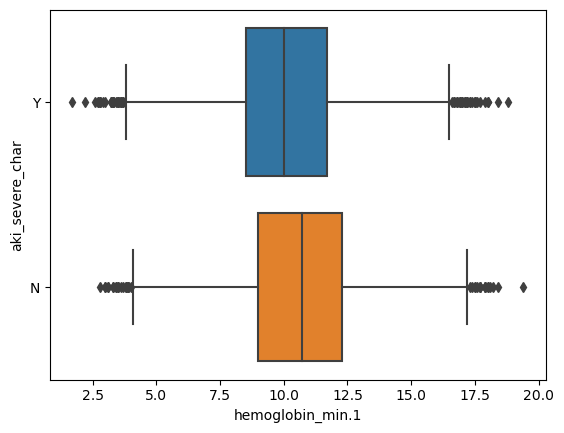

In [286]:
#Top columns: cited in literature on AKI prediction in MIMIC; happen to also have high fillrates

lit_col_num = ["age_clean", "sbp_min", "spo2_mean", "glucose_max", "hemoglobin_min.1", 
"hemoglobin_max.1", "platelets_min", "bicarbonate_min.1", "bun_max", "calcium_min.1", "calcium_max.1", 
"potassium_max.1", "inr_max", "ptt_min"]

lit_col_char = ['gender_M', 'race_clean_NON_BLACK_AA']

print(train[lit_col_num+lit_col_char].info(verbose=True, show_counts=True))

#def have issuesl ike glucse max, maybe als platelets , ptt min at 150
print(train[lit_col_num].describe())

sns.boxplot(data=train, x="hemoglobin_min.1", y="aki_severe_char")
#add more



In [287]:
print(x_train.shape)
print(train.shape) #should just be 1 more

(35644, 90)
(35644, 91)


In [288]:
print(train.info(verbose=True, show_counts=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35644 entries, 12887 to 15725
Data columns (total 91 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       35644 non-null  object 
 1   race                     35644 non-null  object 
 2   heart_rate_min           35590 non-null  float64
 3   heart_rate_max           35590 non-null  float64
 4   heart_rate_mean          35590 non-null  float64
 5   sbp_min                  35578 non-null  float64
 6   sbp_max                  35578 non-null  float64
 7   sbp_mean                 35578 non-null  float64
 8   dbp_min                  35578 non-null  float64
 9   dbp_max                  35578 non-null  float64
 10  dbp_mean                 35578 non-null  float64
 11  mbp_min                  35568 non-null  float64
 12  mbp_max                  35568 non-null  float64
 13  mbp_mean                 35568 non-null  float64
 14  resp_rate_min     

In [289]:
#create list of all non-char columns
#num_cols_list = x_train.select_dtypes(include=np.number).columns.tolist()
num_cols_list = x_train.select_dtypes("float64").columns.tolist()

#num_cols_list.remove("aki_severe")

print(len(num_cols_list))
print(num_cols_list)

#confirm: 
#print(len(train.columns.tolist()))
#print(len(train.select_dtypes("object").columns.tolist()))

80
['heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max', 'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max', 'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1', 'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1', 'potassium_min.1', 'potassium_max.1', 'abs_basophils_min', 'abs_basophils_max', 'abs_eosinophils_min', 'abs_eosinophils_max', 'abs_lymphocytes_m

### Deal with Outliers ###
(will make exploration more useful - visuals are getting compressed by impossibly high values


In [290]:
print(x_train.columns)

print(x_train.shape)

Index(['id', 'race', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1',
       'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max',
       'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1',
       'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1',
       'potassium_min.1', 'potassium_max.1'

In [291]:
#outliers: 2-3, so assuming the data is close enough to a normal distribution, 3 sd give us 99% of data, etc

x_train_withoutliers = x_train

#loop through columns and remove outliers far from mean (3x standard deviation)
print(x_train.shape[0])

#these are clinically bound and are already clean
skip_outlier_removal_list = ["gcs_min", "gcs_motor", "gcs_verbal", "gcs_eyes", "lactate_max_GT2", "lactate_max_GT4", "ck_cpk_max_GT120",
    "ph_min_missing"]

#either: lit_col_num, num_cols_list
for c in num_cols_list:
                    
    #start = x_train.shape[0]
    print(f"""now processing {c}""")
    
    if c in skip_outlier_removal_list:
        print("skipped") 
        
    else:
        upper = x_train[c].mean() + 3*x_train[c].std()
        lower = x_train[c].mean() - 3*x_train[c].std()  #may go negative - ok if I'm not setting to that value 

        #drop: x_train = x_train[(x_train[c] >= lower) & (x_train[c] <= upper) | (x_train[c].isna())]
        #truncate: [lower if x < lower else upper if x > upper else x for x in x_train["glucose_max"]]

        #set to missing: (same as dropping but leaves in rows for other calcs)
        x_train[c] = [np.NAN if x < lower else np.NAN if x > upper else x for x in x_train[c]]

        #end = x_train.shape[0]

        #print(f"""change: {end - start}""")               

        

#confirm no rows dropped
print(x_train.shape)   


35644
now processing heart_rate_min
now processing heart_rate_max
now processing heart_rate_mean
now processing sbp_min
now processing sbp_max
now processing sbp_mean
now processing dbp_min
now processing dbp_max
now processing dbp_mean
now processing mbp_min
now processing mbp_max
now processing mbp_mean
now processing resp_rate_min
now processing resp_rate_max
now processing resp_rate_mean
now processing temperature_min
now processing temperature_max
now processing temperature_mean
now processing spo2_min
now processing spo2_max
now processing spo2_mean
now processing glucose_min
now processing glucose_max
now processing glucose_mean
now processing ph_min
now processing ph_max
now processing po2_min
now processing po2_max
now processing pco2_min
now processing pco2_max
now processing baseexcess_min
now processing baseexcess_max
now processing totalco2_min
now processing totalco2_max
now processing hematocrit_min.1
now processing hematocrit_max.1
now processing hemoglobin_min.1
now pr

In [292]:
print(x_train.shape)

(35644, 90)


In [293]:
print(x_train["glucose_max"].describe())

count    34786.000000
mean       175.871067
std         87.836833
min         43.000000
25%        122.000000
50%        156.000000
75%        200.000000
max       2440.000000
Name: glucose_max, dtype: float64


In [294]:
#re create single dataset (now with outliers set to missing)
train = pd.concat([x_train,y_train],axis=1)

print(train.columns)
print(x_train.columns)

Index(['id', 'race', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1',
       'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max',
       'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1',
       'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1',
       'potassium_min.1', 'potassium_max.1'

### Continue Exploring ###

<Axes: xlabel='age_clean', ylabel='aki_severe_char'>

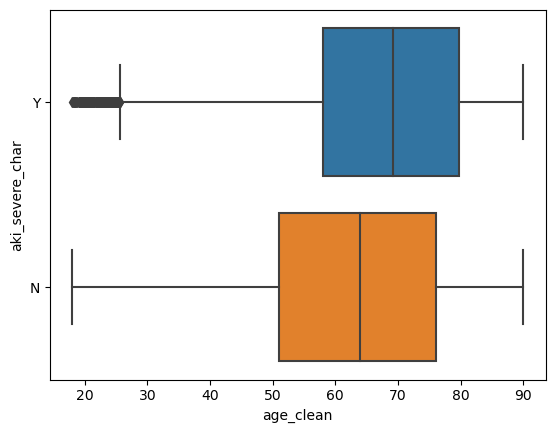

In [295]:
sns.boxplot(data=train, x="age_clean", y="aki_severe_char")

count    34786.000000
mean       175.871067
std         87.836833
min         43.000000
25%        122.000000
50%        156.000000
75%        200.000000
max       2440.000000
Name: glucose_max, dtype: float64


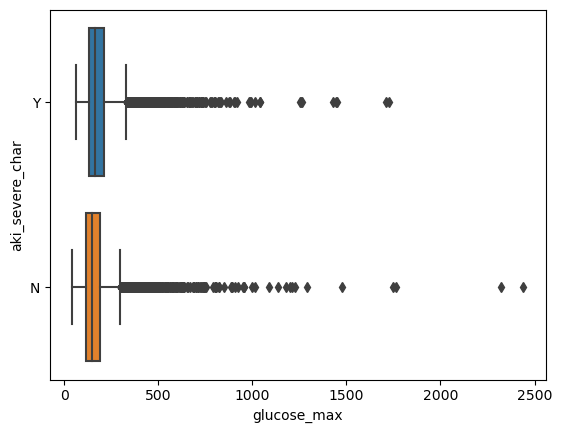

In [296]:
#huge values here - remove outliers now so visuals are more useful
sns.boxplot(data=train, x="glucose_max", y="aki_severe_char")

print(train["glucose_max"].describe())

In [297]:
#how many of the min vs max vars actually have variation? 
    #if there is a min and max when there is typically only one measurement, could have collinearity issues
def check_range(label, l):

    train['max_diff'] = train[l].max(axis=1) - train[l].min(axis=1)
    
    median_range = train["max_diff"].median()
    
    return print(f"""{label} median: {median_range} """)


glucose_list = ["glucose_min", "glucose_max"]

hemo_list = ["hemoglobin_min.1", "hemoglobin_max.1"]

calcium_list = ["calcium_min.1", "calcium_max.1"]


#these seem ok
check_range('glucose',glucose_list)
check_range('hemoglobin1',hemo_list)
check_range('calcium',calcium_list)

#remove - don't want as a feature
train.drop(columns=["max_diff"])



glucose median: 45.0 
hemoglobin1 median: 1.0 
calcium median: 0.1999999999999993 


,id,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,...,aki_severe_char,lactate_max_GT2,lactate_max_GT4,ck_cpk_max_GT120,ph_min_missing,age_clean,gender_M,race_clean_NON_BLACK_AA,gcs_unable_1,aki_severe
12887,31783914,WHITE,50.0,92.0,63.142857,96.0,139.0,111.315789,57.0,84.0,...,Y,0,0,0,1,43.403580,0,1,0,1
15127,36125872,WHITE - OTHER EUROPEAN,64.0,87.0,77.900000,98.0,153.0,127.433333,46.0,89.0,...,N,0,0,0,1,55.633284,0,1,0,0
8644,32267488,BLACK/AFRICAN AMERICAN,108.0,133.0,121.040000,111.0,185.0,146.958333,79.0,109.0,...,N,0,0,1,0,62.672269,1,0,0,0
2290,38460352,WHITE,72.0,112.0,90.260870,138.0,163.0,152.250000,76.0,109.0,...,N,0,0,0,1,88.954309,1,1,0,0
28408,39940480,WHITE,59.0,96.0,81.925926,99.0,140.0,130.111111,55.0,88.0,...,N,0,0,0,1,55.157373,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,37271875,WHITE,82.0,126.0,99.360000,89.0,120.0,102.040000,44.0,85.0,...,Y,0,0,0,0,85.848424,1,1,0,1
15377,32632327,WHITE,59.0,105.0,74.884615,125.0,211.0,152.040000,72.0,111.0,...,N,0,0,0,1,54.990983,0,1,0,0
17730,31247074,WHITE,62.0,85.0,72.400000,97.0,200.0,140.950000,48.0,110.0,...,Y,0,0,0,0,69.938326,1,1,0,1
28030,37000699,UNKNOWN,53.0,89.0,76.230769,101.0,145.0,118.538461,44.0,71.0,...,N,0,0,0,0,75.221326,1,1,0,0


In [298]:
#Could have also considered one way anova; could try as a sensitvity if time 

In [299]:
#do two vars together 

#bun and glucose max

#sns.jointplot(‘Daily Time Spent on Site’,’Daily Internet Usage’ ,data=ad_data,color=’green’)



In [300]:
#if time: improve visuals by embedding lables in the visuals
    #https://medium.com/analytics-vidhya/logistic-regression-in-python-using-pandas-and-seaborn-for-beginners-in-ml-64eaf0f208d2

#to do: turn on when done - takes time to run :) 
#sns.pairplot(data=train[["glucose_max", "bun_max", "hemoglobin_min.1", "hemoglobin_max.1", "aki_severe"]], hue="aki_severe")


<Axes: >

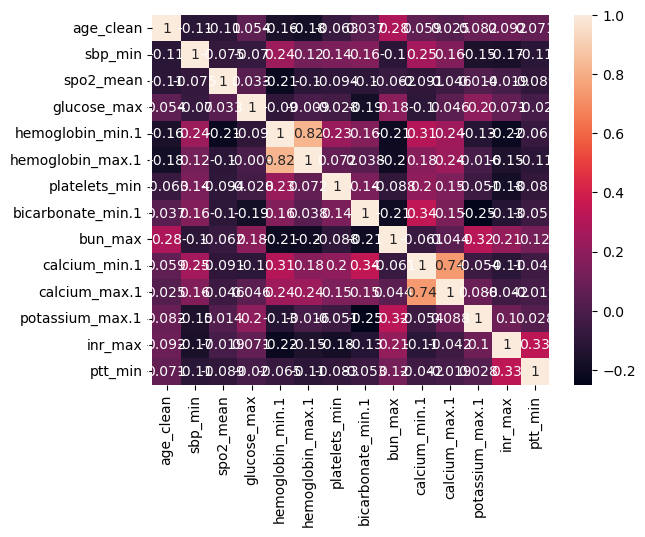

In [301]:
#Collinearity between these? 
    #hemogloblin min/max up at 0.82, calc at 0.59
    #but mostly under 0.25
    
sns.heatmap(x_train[lit_col_num].corr(), annot=True)

In [302]:
#remove highly collinear ones; pick var in the pair cited by two papers rather than 1 paper 
print(len(lit_col_num))
print(lit_col_num)

lit_col_num = [i for i in lit_col_num if i != "hemoglobin_max.1"]
lit_col_num = [i for i in lit_col_num if i != "calcium_max.1"]

print(len(lit_col_num))
print(lit_col_num)


14
['age_clean', 'sbp_min', 'spo2_mean', 'glucose_max', 'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min', 'bicarbonate_min.1', 'bun_max', 'calcium_min.1', 'calcium_max.1', 'potassium_max.1', 'inr_max', 'ptt_min']
12
['age_clean', 'sbp_min', 'spo2_mean', 'glucose_max', 'hemoglobin_min.1', 'platelets_min', 'bicarbonate_min.1', 'bun_max', 'calcium_min.1', 'potassium_max.1', 'inr_max', 'ptt_min']


<Axes: >

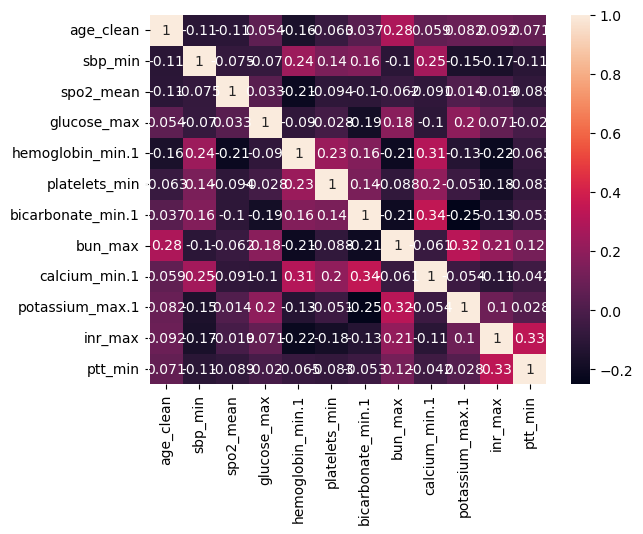

In [303]:
sns.heatmap(x_train[lit_col_num].corr(), annot=True)

In [304]:
# from Daniel - can read these numbers more easily but the colors above are pretty helpful 
print(round(train[lit_col_num].apply(train[lit_col_num].corrwith),2))

                   age_clean  sbp_min  spo2_mean  glucose_max  \
age_clean               1.00    -0.11      -0.11         0.05   
sbp_min                -0.11     1.00      -0.07        -0.07   
spo2_mean              -0.11    -0.07       1.00         0.03   
glucose_max             0.05    -0.07       0.03         1.00   
hemoglobin_min.1       -0.16     0.24      -0.21        -0.09   
platelets_min          -0.06     0.14      -0.09        -0.03   
bicarbonate_min.1       0.04     0.16      -0.10        -0.19   
bun_max                 0.28    -0.10      -0.06         0.18   
calcium_min.1           0.06     0.25      -0.09        -0.10   
potassium_max.1         0.08    -0.15       0.01         0.20   
inr_max                 0.09    -0.17      -0.02         0.07   
ptt_min                 0.07    -0.11      -0.09        -0.02   

                   hemoglobin_min.1  platelets_min  bicarbonate_min.1  \
age_clean                     -0.16          -0.06               0.04   
sbp_min 

In [305]:
#to learn about: papers are using VIF; also research visualizations in case there are non-linear correlations 

### Normalize numeric IVs ###

In [306]:
print(x_train.shape)

print(x_train.select_dtypes("object").shape)

print(x_train.select_dtypes("float64").shape)

#normalization will include gcs - ok, but not gender or aki (good)
print(num_cols_list)

(35644, 90)
(35644, 3)
(35644, 80)
['heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max', 'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max', 'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1', 'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1', 'potassium_min.1', 'potassium_max.1', 'abs_basophils_min', 'abs_basophils_max', 'abs_eosinophils_min', 'abs_eosi

In [307]:
x_num = x_train[num_cols_list]

x_num_norm = (x_num-x_num.mean())/x_num.std()

#confirmed means are right around 0 and std dev is right around 1 
x_num_norm.describe()

,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,mbp_min,...,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,weight_admit,age_clean
count,3.535100e+04,3.531100e+04,3.540900e+04,3.523600e+04,3.527000e+04,3.533200e+04,3.531100e+04,3.519400e+04,3.536600e+04,3.500200e+04,...,3.144500e+04,3.153500e+04,3.131900e+04,3.038500e+04,3.548400e+04,3.519900e+04,3.529800e+04,3.537800e+04,3.485600e+04,3.564400e+04
mean,-5.828899e-17,-3.048546e-16,-3.728398e-16,4.521049e-16,5.820125e-16,3.282027e-16,-2.052487e-17,1.695902e-17,3.399418e-16,1.603705e-16,...,-4.520403e-16,1.926475e-16,4.141562e-16,7.459705e-17,2.747336e-16,7.993833e-17,-8.051932e-17,-3.454501e-17,1.278145e-16,-1.495082e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.076991e+00,-3.094909e+00,-3.062732e+00,-3.173090e+00,-3.170818e+00,-3.095308e+00,-3.037942e+00,-3.265876e+00,-3.043777e+00,-3.374138e+00,...,-1.768192e+00,-1.245944e+00,-3.802818e+00,-1.165612e+00,-4.057096e+00,-2.503327e+00,-1.615568e+00,-1.916919e+00,-3.604341e+00,-2.725058e+00
25%,-6.675238e-01,-7.186494e-01,-7.098912e-01,-6.257220e-01,-7.338317e-01,-7.238591e-01,-6.406648e-01,-7.035542e-01,-7.047895e-01,-6.218312e-01,...,-5.971051e-01,-5.804374e-01,-6.168417e-01,-5.496255e-01,1.092600e-01,-1.004853e-01,-1.137789e+00,-1.117695e-01,-6.825473e-01,-6.050013e-01
50%,-1.167884e-01,-9.875565e-02,-8.503334e-02,-7.985732e-02,-7.772009e-02,-1.261113e-01,-1.914844e-02,-1.465277e-01,-1.048316e-01,-5.517982e-02,...,-2.581063e-01,-2.926508e-01,-2.255815e-01,-3.423779e-01,4.880196e-01,5.002252e-01,7.733293e-01,7.908053e-01,-1.197981e-01,1.124897e-01
75%,6.404727e-01,6.244537e-01,6.499931e-01,5.873106e-01,6.252566e-01,6.334544e-01,6.023679e-01,5.776068e-01,6.160505e-01,5.924217e-01,...,2.349829e-01,1.390292e-01,3.054145e-01,6.636051e-02,4.880196e-01,5.002252e-01,7.733293e-01,7.908053e-01,5.374929e-01,7.724055e-01
max,3.118782e+00,3.155687e+00,3.103366e+00,3.165005e+00,3.202838e+00,3.145586e+00,3.088433e+00,3.362739e+00,3.128551e+00,3.263778e+00,...,5.474056e+00,5.930735e+00,5.154246e+00,5.293607e+00,4.880196e-01,5.002252e-01,7.733293e-01,7.908053e-01,5.210562e+00,1.473957e+00


In [308]:
#put into a dict for later
print(x_num.head())


       heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  \
12887            50.0            92.0        63.142857     96.0    139.0   
15127            64.0            87.0        77.900000     98.0    153.0   
8644            108.0           133.0       121.040000    111.0    185.0   
2290             72.0           112.0        90.260870    138.0    163.0   
28408            59.0            96.0        81.925926     99.0    140.0   

         sbp_mean  dbp_min  dbp_max   dbp_mean  mbp_min  ...  pt_min  pt_max  \
12887  111.315789     57.0     84.0  66.473684     68.0  ...    10.7    10.7   
15127  127.433333     46.0     89.0  63.533333     55.0  ...    11.8    11.8   
8644   146.958333     79.0    109.0  91.875000     91.0  ...    12.2    13.3   
2290   152.250000     76.0    109.0  94.166667      NaN  ...    11.1    11.2   
28408  130.111111     55.0     88.0  74.037037     71.0  ...    11.1    11.1   

       ptt_min  ptt_max  gcs_min  gcs_motor  gcs_verbal  gcs_e

In [309]:
print(raw.info(verbose=True, show_counts=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50920 entries, 0 to 50919
Data columns (total 91 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       50920 non-null  object 
 1   race                     50920 non-null  object 
 2   heart_rate_min           50841 non-null  float64
 3   heart_rate_max           50841 non-null  float64
 4   heart_rate_mean          50841 non-null  float64
 5   sbp_min                  50823 non-null  float64
 6   sbp_max                  50823 non-null  float64
 7   sbp_mean                 50823 non-null  float64
 8   dbp_min                  50823 non-null  float64
 9   dbp_max                  50823 non-null  float64
 10  dbp_mean                 50823 non-null  float64
 11  mbp_min                  50805 non-null  float64
 12  mbp_max                  50805 non-null  float64
 13  mbp_mean                 50805 non-null  float64
 14  resp_rate_min         

In [310]:
#re-combine with char
x_train = pd.concat([x_num_norm,x_train.select_dtypes(exclude=["float"])],axis=1)
print(x_train.shape)

train = pd.concat([x_train,y_train],axis=1)

print(train.shape)



(35644, 90)
(35644, 91)


In [311]:
#print(train.info(verbose=True, show_counts=True))


### Narrow Features via Simple Tests ###

In [312]:
p_value_threshold = 0.05

In [313]:
#char variables found in the literature
print(lit_col_char)

#print(x_train.select_dtypes("object"))

#print(train.columns)

['gender_M', 'race_clean_NON_BLACK_AA']


#### Analyze categorical vars ####

In [314]:
# Gender: 

c = "gender_M"

#here, need to add it not as a list
two_col_list = ["aki_severe"] + [c]
print(two_col_list)
    
#keep only that col and drop rows with missing values given logistic reg can't handle them 
temp_x = train[two_col_list].dropna()
    
#print(temp_x)
    
#then split into x-y
univar_y = temp_x.iloc[:,0]
#print(univar_y)

#Note: univariate doesn't require reshaping like sklearn does 
univar_x = temp_x.iloc[:,1]
#print(univar_x)

clf = sm.Logit(univar_y, univar_x).fit()

print(f"""coef: {clf.params}""")
print(f"""p-value: {clf.pvalues}""")

['aki_severe', 'gender_M']
Optimization terminated successfully.
         Current function value: 0.692785
         Iterations 3
coef: gender_M   -0.072011
dtype: float64
p-value: gender_M    3.729179e-07
dtype: float64


In [315]:
#Race:

c = ['race_clean_NON_BLACK_AA']

#here, need to add it not as a list
two_col_list = ["aki_severe"] + c
print(two_col_list)
    
#keep only that col and drop rows with missing values given logistic reg can't handle them 
temp_x = train[two_col_list].dropna()
    
#print(temp_x)
    
#then split into x-y
univar_y = temp_x.iloc[:,0]
#print(univar_y)

#Note: univariate doesn't require reshaping like sklearn does 
univar_x = temp_x.iloc[:,1:]
#print(univar_x)

clf = sm.Logit(univar_y, univar_x).fit()

print(f"""coef: {clf.params}""")
print(f"""p-value: {clf.pvalues}""")



['aki_severe', 'race_clean_NON_BLACK_AA']
Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 3
coef: race_clean_NON_BLACK_AA   -0.09969
dtype: float64
p-value: race_clean_NON_BLACK_AA    3.440079e-19
dtype: float64


In [316]:
#GSC Unable:

c = [ 'gcs_unable_1']

#here, need to add it not as a list
two_col_list = ["aki_severe"] + c
print(two_col_list)
    
#keep only that col and drop rows with missing values given logistic reg can't handle them 
temp_x = train[two_col_list].dropna()
    
#print(temp_x)
    
#then split into x-y
univar_y = temp_x.iloc[:,0]
#print(univar_y)

#Note: univariate doesn't require reshaping like sklearn does 
univar_x = temp_x.iloc[:,1:]
#print(univar_x)

clf = sm.Logit(univar_y, univar_x).fit()

print(f"""coef: {clf.params}""")
print(f"""p-value: {clf.pvalues}""")

['aki_severe', 'gcs_unable_1']
Optimization terminated successfully.
         Current function value: 0.688069
         Iterations 4
coef: gcs_unable_1    0.449284
dtype: float64
p-value: gcs_unable_1    9.202639e-79
dtype: float64


In [317]:
#lactate_max_GT2 / 4 - both are significant, but take 4 given larger effect (clinical debate over 2 vs 4) 

c = [ 'lactate_max_GT4'] #lactate_max_GT2

#here, need to add it not as a list
two_col_list = ["aki_severe"] + c
print(two_col_list)
    
#keep only that col and drop rows with missing values given logistic reg can't handle them 
temp_x = train[two_col_list].dropna()
    
#print(temp_x)
    
#then split into x-y
univar_y = temp_x.iloc[:,0]
#print(univar_y)

#Note: univariate doesn't require reshaping like sklearn does 
univar_x = temp_x.iloc[:,1:]
#print(univar_x)

clf = sm.Logit(univar_y, univar_x).fit()

print(f"""coef: {clf.params}""")
print(f"""p-value: {clf.pvalues}""")

['aki_severe', 'lactate_max_GT4']
Optimization terminated successfully.
         Current function value: 0.689730
         Iterations 4
coef: lactate_max_GT4    0.667895
dtype: float64
p-value: lactate_max_GT4    4.427030e-52
dtype: float64


In [318]:
#ck_cpk_max_GT120

c = [ 'ck_cpk_max_GT120'] 

#here, need to add it not as a list
two_col_list = ["aki_severe"] + c
print(two_col_list)
    
#keep only that col and drop rows with missing values given logistic reg can't handle them 
temp_x = train[two_col_list].dropna()
    
#print(temp_x)
    
#then split into x-y
univar_y = temp_x.iloc[:,0]
#print(univar_y)

#Note: univariate doesn't require reshaping like sklearn does 
univar_x = temp_x.iloc[:,1:]
#print(univar_x)

clf = sm.Logit(univar_y, univar_x).fit()

print(f"""coef: {clf.params}""")
print(f"""p-value: {clf.pvalues}""")

['aki_severe', 'ck_cpk_max_GT120']
Optimization terminated successfully.
         Current function value: 0.691411
         Iterations 4
coef: ck_cpk_max_GT120    0.272605
dtype: float64
p-value: ck_cpk_max_GT120    1.666099e-28
dtype: float64


In [319]:
#"ph_min_missing" - very negative, interesting

c = [ 'ph_min_missing'] 

#here, need to add it not as a list
two_col_list = ["aki_severe"] + c
print(two_col_list)
    
#keep only that col and drop rows with missing values given logistic reg can't handle them 
temp_x = train[two_col_list].dropna()
    
#print(temp_x)
    
#then split into x-y
univar_y = temp_x.iloc[:,0]
#print(univar_y)

#Note: univariate doesn't require reshaping like sklearn does 
univar_x = temp_x.iloc[:,1:]
#print(univar_x)

clf = sm.Logit(univar_y, univar_x).fit()

print(f"""coef: {clf.params}""")
print(f"""p-value: {clf.pvalues}""")

['aki_severe', 'ph_min_missing']
Optimization terminated successfully.
         Current function value: 0.676637
         Iterations 4
coef: ph_min_missing   -0.597673
dtype: float64
p-value: ph_min_missing    6.697132e-247
dtype: float64


In [320]:
#Decision: both gender and race will stay in, as expected
    #gsc unable actually has a large coefficient - probably proxy for intubation. 
    #Intubation is a known AKI risk factor, so add it to the lit list 
    #rest are *inspired* by lit so add them in here for convenience 

lit_col_char = ["gender_M", "race_clean_NON_BLACK_AA", "gcs_unable_1", "lactate_max_GT4", "ck_cpk_max_GT120", "ph_min_missing"]


#### Numeric ####

In [321]:
#Zimmerman 2019: Univariate logistic regression 
    #Switch to statsmodels b/c sklearn doesn't automatically give you the IV p-values 

univar_results = []
coefs_to_check = [] 
p_values_to_check = []


for c in lit_col_num:
   
    print(f"""now running univariate log. regression for {c}""")
    
    two_col_list = ["aki_severe"] + [c]
    #print(two_col_list)
    
    #keep only that col and drop rows with missing values given logistic reg can't handle them 
    temp_x = train[two_col_list].dropna()
    
    #print(temp_x)
    
    #then split into x-y
    univar_y = temp_x.iloc[:,0]
    #print(univar_y)

    #Note: univariate doesn't require reshaping like sklearn does 
    univar_x = temp_x.iloc[:,1]
    #print(univar_x)

    clf = sm.Logit(univar_y, univar_x).fit()

    print(f"""coef: {clf.params}""")
    print(f"""p-value: {clf.pvalues}""")
    
    #store varname if significant in univariate  
        
    if clf.pvalues[0] <= p_value_threshold:
        univar_results.append(c)
        coefs_to_check.append(clf.params.values[0])
        p_values_to_check.append(clf.pvalues.values[0])


#storage:
    #full summary 
    #print(clf.summary())

    #can grab out coefficients and pvalues from here
    #print(dir(clf))

now running univariate log. regression for age_clean
Optimization terminated successfully.
         Current function value: 0.680347
         Iterations 4
coef: age_clean    0.325733
dtype: float64
p-value: age_clean    1.296820e-193
dtype: float64
now running univariate log. regression for sbp_min
Optimization terminated successfully.
         Current function value: 0.680703
         Iterations 4
coef: sbp_min   -0.32223
dtype: float64
p-value: sbp_min    5.168488e-185
dtype: float64
now running univariate log. regression for spo2_mean
Optimization terminated successfully.
         Current function value: 0.692978
         Iterations 3
coef: spo2_mean   -0.036835
dtype: float64
p-value: spo2_mean    0.000545
dtype: float64
now running univariate log. regression for glucose_max
Optimization terminated successfully.
         Current function value: 0.688425
         Iterations 5
coef: glucose_max    0.20912
dtype: float64
p-value: glucose_max    3.252963e-67
dtype: float64
now running 

In [322]:
#see how many made it in:
print(len(lit_col_num))
print(len(univar_results))
print(univar_results)

#brings me down to 10 num; after normalization takes me to 12 but some are smaller coefficients than others 
#running this pre-normalization: ['sbp_min', 'spo2_mean', 'glucose_max', 'hemoglobin_min.1', 'platelets_min', 'bicarbonate_min.1', 'bun_max', 'calcium_min.1', 'potassium_max.1', 'inr_max']


12
12
['age_clean', 'sbp_min', 'spo2_mean', 'glucose_max', 'hemoglobin_min.1', 'platelets_min', 'bicarbonate_min.1', 'bun_max', 'calcium_min.1', 'potassium_max.1', 'inr_max', 'ptt_min']


In [323]:
#https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/

data_tuples = list(zip(univar_results,coefs_to_check,p_values_to_check))

#print(data_tuples)

#convert to df 
univariate_combined_lit = pd.DataFrame(data_tuples, columns = ['variable', 'coef', 'pvalue'])

#add an absolute value column for coef
univariate_combined_lit["coef_abs"] = univariate_combined_lit["coef"].abs()

#print(univariate_combined.head())
#print(univariate_combined.info())

#display in order 
print(univariate_combined_lit.sort_values("coef_abs", ascending=False))

             variable      coef         pvalue  coef_abs
7             bun_max  0.403595  1.178304e-249  0.403595
0           age_clean  0.325733  1.296820e-193  0.325733
1             sbp_min -0.322230  5.168488e-185  0.322230
10            inr_max  0.304064  1.046077e-125  0.304064
9     potassium_max.1  0.277701  5.460419e-136  0.277701
4    hemoglobin_min.1 -0.225652   1.903672e-96  0.225652
3         glucose_max  0.209120   3.252963e-67  0.209120
11            ptt_min  0.196500   5.189439e-63  0.196500
8       calcium_min.1 -0.190979   2.923120e-63  0.190979
6   bicarbonate_min.1 -0.170567   3.071906e-55  0.170567
5       platelets_min -0.149668   1.577280e-43  0.149668
2           spo2_mean -0.036835   5.451262e-04  0.036835


<Axes: xlabel='coef_abs', ylabel='variable'>

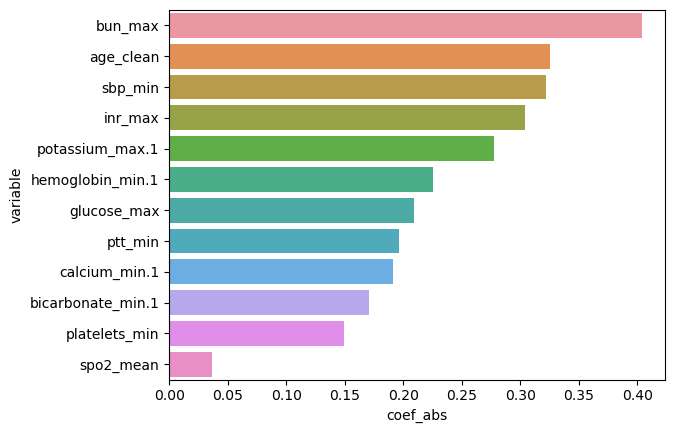

In [324]:
#visualize - natural break between potmax1 (27.7) and glucose_max (20.9)
sns.barplot(data=univariate_combined_lit.sort_values("coef_abs", ascending=False), x="coef_abs", y="variable")

In [325]:
#Update lit numeric columns to just these top 5
lit_col_num = univariate_combined_lit.sort_values("coef_abs", ascending=False).iloc[0:5,0].values.tolist()

print(lit_col_num)

['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1']


<Axes: >

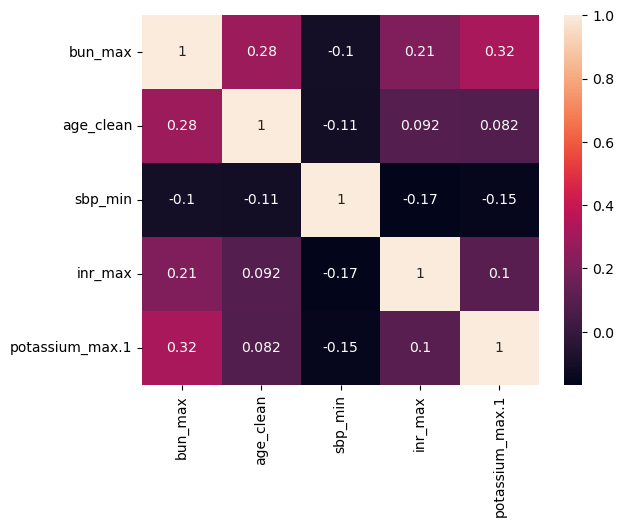

In [326]:
#recheck correlation
    #highest is 0.32 - ok 
sns.heatmap(x_train[lit_col_num].corr(), annot=True)

#can make it look nicer: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e


In [327]:
print(train.columns)

Index(['heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min',
       'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min',
       'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1',
       'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max',
       'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1',
       'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1',
       'potassium_min.1', 'potassium_max.1', 'abs_basophi

In [328]:
#correlation coefficient gets at linear correlation - take a look for other relationships
    #look ok 
    
#to do: turn back on later - takes awhile to run :) sns.pairplot(data=train[lit_col_num + ["aki_severe"]], hue="aki_severe")



#### Narrow rest of features in the same way ####

In [329]:
print(len(num_cols_list)) #this contains the earlier ones but it's ok b/c data is small and can remove dups after

#print(len(x_train.select_dtypes("float64").columns))

print((num_cols_list)) #this contains the earlier ones but it's ok b/c data is small and can remove dups after

#print((x_train.select_dtypes("float64").columns))


80
['heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max', 'totalco2_min', 'totalco2_max', 'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max', 'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1', 'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1', 'potassium_min.1', 'potassium_max.1', 'abs_basophils_min', 'abs_basophils_max', 'abs_eosinophils_min', 'abs_eosinophils_max', 'abs_lymphocytes_m

In [330]:


#empty out:
univar_results = []
coefs_to_check = [] 
p_values_to_check = []


for c in num_cols_list:
   
    print(f"""now running univariate log. regression for {c}""")
    
    if c in lit_col_num:
        print("skipped") 
        
    else:
    
        two_col_list = ["aki_severe"] + [c]
        #print(two_col_list)

        #keep only that col and drop rows with missing values given logistic reg can't handle them 
        temp_x = train[two_col_list].dropna()

        #print(temp_x)

        #then split into x-y
        univar_y = temp_x.iloc[:,0]
        #print(univar_y)

        #Note: univariate doesn't require reshaping like sklearn does 
        univar_x = temp_x.iloc[:,1]
        #print(univar_x)

        clf = sm.Logit(univar_y, univar_x).fit()

        print(f"""coef: {clf.params}""")
        print(f"""p-value: {clf.pvalues}""")

        #store varname if significant in univariate  

        if clf.pvalues[0] <= p_value_threshold:
            univar_results.append(c)
            coefs_to_check.append(clf.params.values[0])
            p_values_to_check.append(clf.pvalues.values[0])        


now running univariate log. regression for heart_rate_min
Optimization terminated successfully.
         Current function value: 0.692299
         Iterations 3
coef: heart_rate_min    0.082477
dtype: float64
p-value: heart_rate_min    1.047388e-14
dtype: float64
now running univariate log. regression for heart_rate_max
Optimization terminated successfully.
         Current function value: 0.690097
         Iterations 4
coef: heart_rate_max    0.156953
dtype: float64
p-value: heart_rate_max    2.421562e-48
dtype: float64
now running univariate log. regression for heart_rate_mean
Optimization terminated successfully.
         Current function value: 0.691095
         Iterations 4
coef: heart_rate_mean    0.128508
dtype: float64
p-value: heart_rate_mean    2.825437e-33
dtype: float64
now running univariate log. regression for sbp_min
skipped
now running univariate log. regression for sbp_max
Optimization terminated successfully.
         Current function value: 0.692176
         Iteration

In [331]:
#see how many made it in:
print(len(lit_col_num))
print(len(univar_results))
print(univar_results)

#oh no - 71 of 83 were stat sig - really? 
#post normalization is 77 
      

5
71
['heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_max', 'glucose_mean', 'ph_min', 'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max', 'totalco2_min', 'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1', 'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'potassium_min.1', 'abs_basophils_min', 'abs_basophils_max', 'abs_eosinophils_min', 'abs_eosinophils_max', 'abs_lymphocytes_min', 'abs_lymphocytes_max', 'abs_monocytes_min', 'abs_monocytes_max', 'abs_neutrophils_min', 'abs

In [332]:
#https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/

data_tuples = list(zip(univar_results,coefs_to_check,p_values_to_check))

#print(data_tuples)

#convert to df 
univariate_combined = pd.DataFrame(data_tuples, columns = ['variable', 'coef', 'pvalue'])

#add an absolute value column for coef
univariate_combined["coef_abs"] = univariate_combined["coef"].abs()

#print(univariate_combined.head())
#print(univariate_combined.info())

#display in order
print(univariate_combined.sort_values("coef_abs", ascending=False).head(30))


               variable      coef         pvalue  coef_abs
42              bun_min  0.400548  1.113110e-245  0.400548
70         weight_admit  0.399015  2.452111e-257  0.399015
68           gcs_verbal -0.365478  5.945168e-244  0.365478
5               dbp_min -0.318688  6.695451e-182  0.318688
7               mbp_min -0.309700  1.033009e-169  0.309700
63               pt_max  0.308484  4.903052e-130  0.308484
69             gcs_eyes -0.295454  5.131484e-161  0.295454
61              inr_min  0.271374  1.491318e-107  0.271374
62               pt_min  0.271138  9.818977e-109  0.271138
6              dbp_mean -0.247344  1.825197e-114  0.247344
65              ptt_max  0.245516   1.567131e-88  0.245516
67            gcs_motor -0.238489  1.311429e-103  0.238489
48        glucose_max.2  0.228996   2.730838e-92  0.228996
12       resp_rate_mean  0.227855   3.073143e-97  0.227855
11        resp_rate_max  0.227849   5.998389e-97  0.227849
32     hemoglobin_min.1 -0.225652   1.903672e-96  0.2256

<Axes: xlabel='coef_abs', ylabel='variable'>

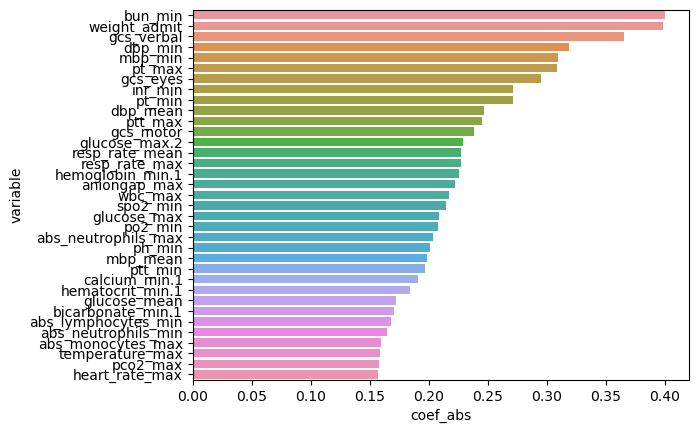

In [333]:
#visualize - take some extra and then look for collinearlity - cut after hematocrit or after abs_neutrofils_min
sns.barplot(data=univariate_combined.sort_values("coef_abs", ascending=False).head(35), x="coef_abs", y="variable")


In [334]:
#if time: replace my univariate feature selection with theirs
    #https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection 
    

In [335]:
#Update lit numeric columns to just these top ones before the break (top 27)
candidate_col_num = univariate_combined.sort_values("coef_abs", ascending=False).iloc[0:27,0].values.tolist()

print(candidate_col_num)


['bun_min', 'weight_admit', 'gcs_verbal', 'dbp_min', 'mbp_min', 'pt_max', 'gcs_eyes', 'inr_min', 'pt_min', 'dbp_mean', 'ptt_max', 'gcs_motor', 'glucose_max.2', 'resp_rate_mean', 'resp_rate_max', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'glucose_max', 'po2_min', 'abs_neutrophils_max', 'ph_min', 'mbp_mean', 'ptt_min', 'calcium_min.1', 'hematocrit_min.1']


In [336]:
#likely some of these are correlated like bun min/max
#sns.heatmap(x_train[lit_col_num + candidate_col_num].corr(), annot=True)


In [337]:
print(lit_col_num)

['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1']


In [338]:
check_corr_list = lit_col_num + candidate_col_num
print(check_corr_list)

to_remove = ["bun_min", "pt_max", "mbp_min", "abs_neutrophils_max", "mbp_mean",  "hematocrit_min.1", "pt_min"
            ,"inr_min", "gcs_eyes", "gcs_motor", "dbp_mean", "glucose_max", "resp_rate_max"]

check_corr_list = [i for i in check_corr_list if i not in to_remove]

print(check_corr_list)


['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'bun_min', 'weight_admit', 'gcs_verbal', 'dbp_min', 'mbp_min', 'pt_max', 'gcs_eyes', 'inr_min', 'pt_min', 'dbp_mean', 'ptt_max', 'gcs_motor', 'glucose_max.2', 'resp_rate_mean', 'resp_rate_max', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'glucose_max', 'po2_min', 'abs_neutrophils_max', 'ph_min', 'mbp_mean', 'ptt_min', 'calcium_min.1', 'hematocrit_min.1']
['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2', 'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1']


In [339]:
corr_threshold = 0.6

cols_to_check = []

corr_df = x_train[check_corr_list].corr()

for c in check_corr_list: 
    #print(c)
    corr_df[c] = [np.nan if x == 1.000 else x if abs(x) > corr_threshold else np.nan for x in corr_df[c]]
    
print(corr_df)   

#Notes:
    #0.8
    #have to remove bun max or min - already picked bun_max from lit review so remove bun_min
    #inr_max with pt_max - Zimmerman has both inr_max. already had picked inr_max 
    #dbp_min and mbp_min - Zimmerman uses sbp_min so I'll just pick one of these. both 100% fill. dbp min has higher effect size so keep
    #wbc_max and abs_neutrophils_max - wbc_max has much high fill rate, so keep that one        
    #mbp_mean and dbp_mean - dpb_mean has higher effect size
    #hematocrit_min.1  and hemoglobin_min.1 - already decided to keep hemoglobin_min.1
    #pt_min and inr_min - same 90% fill rate, keep larger effect size of inr_min

    #0.6:
    #inr min and max - already picked inr max 
    #gcs_verbal with gcs_eyes, gcs_motor - keep verbal - highest effect size in univariate 
    #dpm_min and dpm_mean - already kept min, drop mean 
    #glucose max and glucose max 2 - 2 has higher effect size 
    #resp_rate max and mean - mean has slightly larger effect size 

       

'''Notes: 

#to remove from candidate_col_num, then rerun corr_width generation 
#knocked out at 0.8   
"bun_min", "pt_max", "mbp_min", "abs_neutrophils_max", "mbp_mean",  "hematocrit_min.1", "pt_min",

#knocked out at 0.6
"inr_min", "gcs_eyes", "gcs_motor", "dbp_mean", "glucose_max", "resp_rate_max"
'''  



                  bun_max  age_clean  sbp_min  inr_max  potassium_max.1  \
bun_max               NaN        NaN      NaN      NaN              NaN   
age_clean             NaN        NaN      NaN      NaN              NaN   
sbp_min               NaN        NaN      NaN      NaN              NaN   
inr_max               NaN        NaN      NaN      NaN              NaN   
potassium_max.1       NaN        NaN      NaN      NaN              NaN   
weight_admit          NaN        NaN      NaN      NaN              NaN   
gcs_verbal            NaN        NaN      NaN      NaN              NaN   
dbp_min               NaN        NaN      NaN      NaN              NaN   
ptt_max               NaN        NaN      NaN      NaN              NaN   
glucose_max.2         NaN        NaN      NaN      NaN              NaN   
resp_rate_mean        NaN        NaN      NaN      NaN              NaN   
hemoglobin_min.1      NaN        NaN      NaN      NaN              NaN   
aniongap_max          NaN

'Notes: \n\n#to remove from candidate_col_num, then rerun corr_width generation \n#knocked out at 0.8   \n"bun_min", "pt_max", "mbp_min", "abs_neutrophils_max", "mbp_mean",  "hematocrit_min.1", "pt_min",\n\n#knocked out at 0.6\n"inr_min", "gcs_eyes", "gcs_motor", "dbp_mean", "glucose_max", "resp_rate_max"\n'

In [340]:
#if time, look into VIF 

In [341]:
print(x_train.shape)

(35644, 90)


['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2', 'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1']


<Axes: >

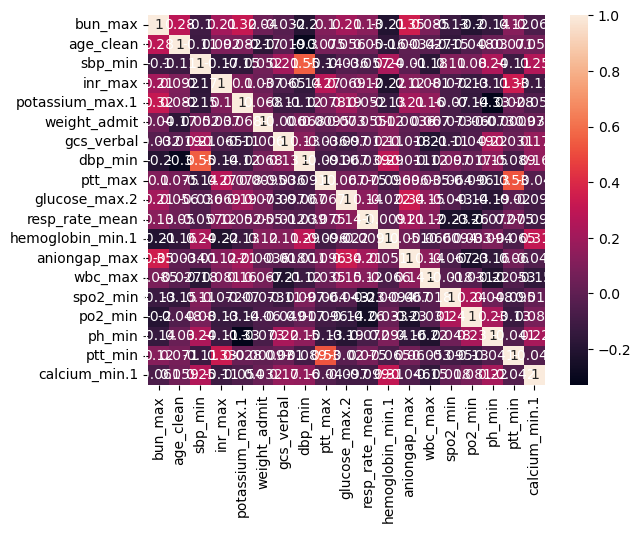

In [342]:
#final list:
    #couple 0.5's in there but I think it's ok 
print(check_corr_list)

#couple ~.5s
sns.heatmap(x_train[check_corr_list].corr(), annot=True)




<Axes: >

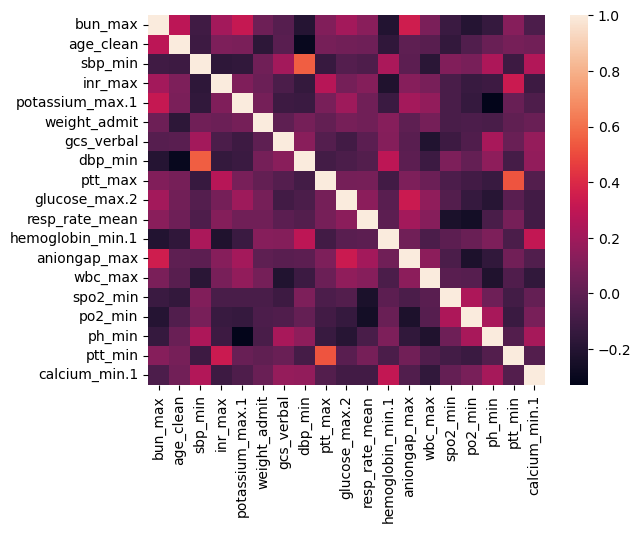

In [343]:
sns.heatmap(x_train[check_corr_list].corr(), annot=False)

In [344]:
#shouldn't be any huge correlation between age, race, gcs unable char vars etc so I'm good there

features_precreation_list = check_corr_list + lit_col_char

print(len(features_precreation_list))
print(features_precreation_list)

25
['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2', 'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1', 'gender_M', 'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'lactate_max_GT4', 'ck_cpk_max_GT120', 'ph_min_missing']


In [345]:
fs_list = features_precreation_list # + fecture_creation_list 
print(len(fs_list))
print(fs_list)

25
['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2', 'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1', 'gender_M', 'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'lactate_max_GT4', 'ck_cpk_max_GT120', 'ph_min_missing']


### Address Missing Values ###

In [346]:
#populate with mean 
    #https://scikit-learn.org/stable/modules/impute.html
    #https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
    #https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer.set_output

In [347]:
print(x_train.shape)
x_train = x_train[fs_list]
print(x_train.shape)

(35644, 90)
(35644, 25)


In [348]:
print(x_train.columns)

print(x_train.info(verbose=True, show_counts=True))

Index(['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
       'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2',
       'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max',
       'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1', 'gender_M',
       'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'lactate_max_GT4',
       'ck_cpk_max_GT120', 'ph_min_missing'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35644 entries, 12887 to 15725
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bun_max                  34527 non-null  float64
 1   age_clean                35644 non-null  float64
 2   sbp_min                  35236 non-null  float64
 3   inr_max                  31550 non-null  float64
 4   potassium_max.1          34525 non-null  float64
 5   weight_admit             34856 non-null  float64
 6   gcs_verbal   

In [349]:
#use set_output to return a pandas df instead of a np array 
imp = SimpleImputer(missing_values=np.nan, strategy='mean').set_output(transform="pandas")

x_train_num = x_train[x_train.select_dtypes("float64").columns]

print(x_train_num.columns)


Index(['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
       'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2',
       'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max',
       'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1'],
      dtype='object')


In [350]:
imp.fit(x_train_num)

SimpleImputer()

x_train_num = imp.transform(x_train_num)

print(x_train_num)



        bun_max  age_clean   sbp_min   inr_max  potassium_max.1  weight_admit  \
12887 -0.807968  -1.243625  0.162749 -0.768756        -1.427259     -1.443384   
15127 -0.745013  -0.530368  0.284052 -0.585637        -1.277329      1.460401   
8644  -0.367277  -0.119843  1.072524 -0.402517        -1.127399      1.257812   
2290  -0.178409   1.412970  2.710118 -0.768756         0.821690     -0.786093   
28408  0.325239  -0.558124  0.344704 -0.768756        -0.077889      0.132313   
...         ...        ...       ...       ...              ...           ...   
7763   1.080710   1.231830 -0.261812 -0.219398        -1.127399     -0.443942   
15377 -0.933880  -0.567828  1.921646 -0.768756        -0.227819     -1.249798   
17730  0.073415   0.303926  0.223401 -0.585637         0.521830     -0.497966   
28030 -0.430233   0.612039  0.466007 -0.219398         0.072041      1.708011   
15725 -0.682057   0.162215  0.647962  0.146840         0.221971     -0.407926   

       gcs_verbal   dbp_min

In [351]:
x_train = pd.concat([x_train_num,x_train.select_dtypes(exclude=["float64"])],axis=1)
print(x_train.shape)
print(x_train.info(verbose=True, show_counts=True))

(35644, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35644 entries, 12887 to 15725
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bun_max                  35644 non-null  float64
 1   age_clean                35644 non-null  float64
 2   sbp_min                  35644 non-null  float64
 3   inr_max                  35644 non-null  float64
 4   potassium_max.1          35644 non-null  float64
 5   weight_admit             35644 non-null  float64
 6   gcs_verbal               35644 non-null  float64
 7   dbp_min                  35644 non-null  float64
 8   ptt_max                  35644 non-null  float64
 9   glucose_max.2            35644 non-null  float64
 10  resp_rate_mean           35644 non-null  float64
 11  hemoglobin_min.1         35644 non-null  float64
 12  aniongap_max             35644 non-null  float64
 13  wbc_max                  35644 non-null  float64
 14  spo2_m

In [352]:
#to learn: try multiple imputation https://scikit-learn.org/stable/modules/impute.html    
    

### Feature Selection ###

#### Prep test data for use in FS ####

In [353]:
#First, subset x_test to same col list as x_train
x_col_list = x_train.columns

print(len(x_col_list))
print(x_col_list)

#subset test date to relevant columns 
x_test = x_test[x_col_list]
print(x_test.shape)


25
Index(['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
       'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2',
       'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max',
       'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1', 'gender_M',
       'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'lactate_max_GT4',
       'ck_cpk_max_GT120', 'ph_min_missing'],
      dtype='object')
(7638, 25)


In [354]:
#Second, fill in missing values with mean to be consistent
    #ponder: use the mean of the test data OR the mean of the training data? am doing training data here
    #this feel right b/c it feels like info leak to use the test; plus in reality, data would come in in a stream, so how would we do mean anyway
    #these people agree, for whatever it's worth https://stackoverflow.com/questions/60131228/how-to-impute-the-missing-value-on-the-test-set 

x_test_num = imp.transform(x_test.select_dtypes("float64"))

SimpleImputer()

#converted all to float - need to NOT apply to bool 
print(x_test.info(verbose=True, show_counts=True))

#recombine with remaining cols
x_test = pd.concat([x_test_num,x_test.select_dtypes(exclude=["float64"])],axis=1)
print(x_test.shape)
print(x_test.info(verbose=True, show_counts=True)) 

print(x_test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7638 entries, 11903 to 27745
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bun_max                  7583 non-null   float64
 1   age_clean                7638 non-null   float64
 2   sbp_min                  7625 non-null   float64
 3   inr_max                  6871 non-null   float64
 4   potassium_max.1          7554 non-null   float64
 5   weight_admit             7491 non-null   float64
 6   gcs_verbal               7550 non-null   float64
 7   dbp_min                  7625 non-null   float64
 8   ptt_max                  6839 non-null   float64
 9   glucose_max.2            7539 non-null   float64
 10  resp_rate_mean           7615 non-null   float64
 11  hemoglobin_min.1         7572 non-null   float64
 12  aniongap_max             7550 non-null   float64
 13  wbc_max                  7577 non-null   float64
 14  spo2_min           

In [355]:
#ponder: if I totally drop the bad values (set to NAN) and THEN impute over iwth missing, is that ok?
    #some on google feel this is ok
    #I think it makes sense in the sense that these seem to be clinically implausible values, so it's like a measurement error
    #which feels safe to set to missing and then do mean imputation 


In [356]:
#combine for use later 
test = pd.concat([x_test,y_test],axis=1)

#### Start with logistic with L1 regularization, which will function as feature selection ####

0.6591291661990798
0.4727677402461377
number of features GE 0.001: 14


weight_admit               0.308619
gcs_verbal                 0.199600
age_clean                  0.189565
bun_max                    0.144261
sbp_min                    0.095864
ph_min_missing             0.093538
inr_max                    0.042945
dbp_min                    0.042591
resp_rate_mean             0.040685
aniongap_max               0.037466
ptt_max                    0.028551
spo2_min                   0.024894
potassium_max.1            0.015957
hemoglobin_min.1           0.014267
wbc_max                    0.000000
glucose_max.2              0.000000
ph_min                     0.000000
ptt_min                    0.000000
calcium_min.1              0.000000
gender_M                   0.000000
race_clean_NON_BLACK_AA    0.000000
gcs_unable_1               0.000000
lactate_max_GT4            0.000000
ck_cpk_max_GT120           0.000000
po2_min                    0.000000
dtype: float64

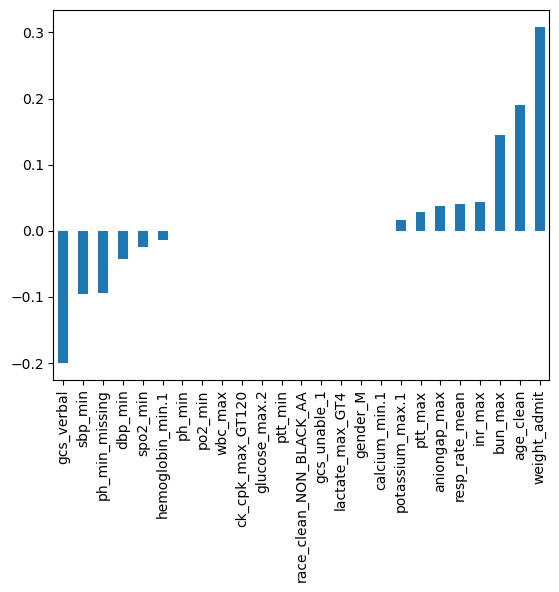

In [357]:
hp_lr_l1_c = 0.001
#hp_lr_l1_c = 0.01
#hp_lr_l1_c = 0.03
#hp_lr_l1_c = 0.05
#hp_lr_l1_c = 0.5
#hp_lr_l1_c = 1 #default 

model_lr_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',  #if I'm using L1, looks like I can only pick liblinear and saga. sklearn recommends for small datasets
    C=hp_lr_l1_c,
    fit_intercept=True
    ).fit(x_train, y_train)

#mean accuracy - here it's more useful than normal b/c I do have a balanced dataset 
train_score_lr_l1 = model_lr_l1.score(x_train,y_train)
test_score_lr_l1 = model_lr_l1.score(x_test,y_test)

print(train_score_lr_l1) 
print(test_score_lr_l1) #is this getting wiped or not?

#print(model_lr_l1.coef_) #nested list for some reason, hence have to add index of 0 below for it to work 

print(f"""number of features GE 0.001: {(abs(model_lr_l1.coef_) >=0.001).sum()}""")
pd.Series(model_lr_l1.coef_[0], x_train.columns).sort_values(ascending = True).plot(kind = "bar")

pd.Series(abs(model_lr_l1.coef_[0]), x_train.columns).sort_values(ascending = False)

0.6557625406800583
0.4727677402461377
number of features GE 0.001: 13


weight_admit               0.311276
gcs_verbal                 0.216669
age_clean                  0.189191
bun_max                    0.142471
sbp_min                    0.102138
resp_rate_mean             0.043579
inr_max                    0.043350
dbp_min                    0.042984
aniongap_max               0.038912
ptt_max                    0.029684
spo2_min                   0.026472
potassium_max.1            0.020604
hemoglobin_min.1           0.020590
glucose_max.2              0.000000
wbc_max                    0.000000
po2_min                    0.000000
ph_min                     0.000000
ptt_min                    0.000000
calcium_min.1              0.000000
gender_M                   0.000000
race_clean_NON_BLACK_AA    0.000000
gcs_unable_1               0.000000
lactate_max_GT4            0.000000
ck_cpk_max_GT120           0.000000
ph_min_missing             0.000000
dtype: float64

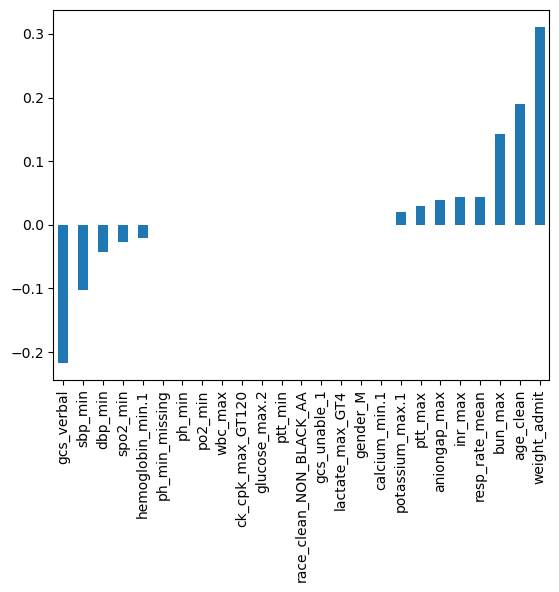

In [358]:
#try with stochastiv average gradient descent - very similar results

hp_lr_l1_c = 0.001
#hp_lr_l1_c = 0.01
#hp_lr_l1_c = 0.03
#hp_lr_l1_c = 0.05
#hp_lr_l1_c = 0.5
#hp_lr_l1_c = 1 #default 

model_lr_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',  #if I'm using L1, looks like I can only pick liblinear and saga. try saga
    C=hp_lr_l1_c,
    fit_intercept=True
    ).fit(x_train, y_train)

#mean accuracy - here it's more useful than normal b/c I do have a balanced dataset 
train_score_lr_l1 = model_lr_l1.score(x_train,y_train)
test_score_lr_l1 = model_lr_l1.score(x_test,y_test)

print(train_score_lr_l1) 
print(test_score_lr_l1) #is this getting wiped or not?

#print(model_lr_l1.coef_) #nested list for some reason, hence have to add index of 0 below for it to work 

print(f"""number of features GE 0.001: {(abs(model_lr_l1.coef_) >=0.001).sum()}""")
pd.Series(model_lr_l1.coef_[0], x_train.columns).sort_values(ascending = True).plot(kind = "bar")

pd.Series(abs(model_lr_l1.coef_[0]), x_train.columns).sort_values(ascending = False)

In [359]:
#ponder why isn't accuracy changing when I change C? 
    #https://stats.stackexchange.com/questions/88000/c-parameter-does-not-affect-accuracy-libsvm
    #confirmed: putting it at 0.0001 removes all variables and brings accuracy *up*, sigh 
    
    
#need to run these with grid search; try other ways for feature selection that have better performance


#### Try L2 regularization (ridge classifiction) ####

0.6666760184042195
0.472636815920398
number of features GE 0.001: 25


<Axes: >

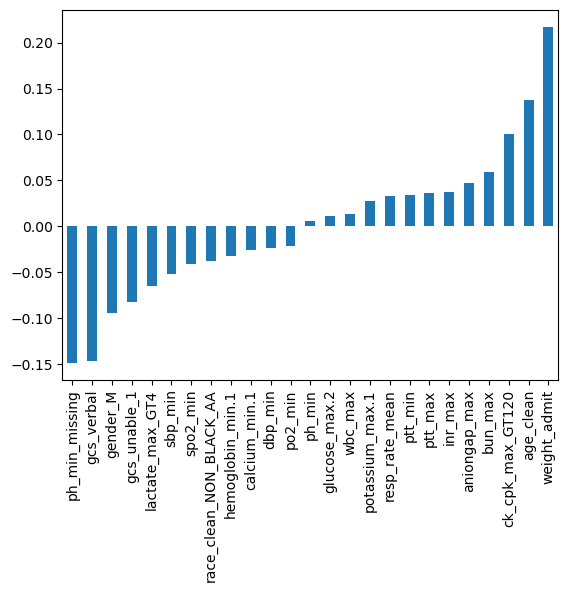

In [360]:
#one ridge classification with full list

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
#hyper parameter alpha. Datacamp hard codes it, but I'll set it as a parameter for flexibility 

hp_ridge_alpha = 2

rc = RidgeClassifier(
    alpha = hp_ridge_alpha, #Alpha corresponds to 1 / (2C)
    fit_intercept = True,
    solver = "saga"    
    ).fit(x_train, y_train)

#also returns mean accuracy
train_score_rc = rc.score(x_train,y_train)
test_score_rc = rc.score(x_test,y_test)

print(train_score_rc)
print(test_score_rc)

print(f"""number of features GE 0.001: {(abs(rc.coef_) >=0.001).sum()}""") #these won't go to 0 b/c it's l2, not l1
pd.Series(rc.coef_[0], x_train.columns).sort_values(ascending = True).plot(kind = "bar")


0.6605319268320053
0.47329143754909664
number of features GE 0.001: 13


<Axes: >

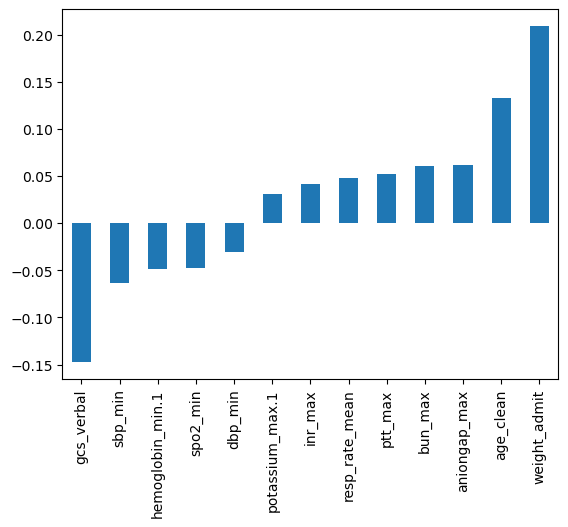

In [361]:
#one ridge regression with smaller list per l1 reg

post_l1_list = ["weight_admit", "gcs_verbal", "age_clean", "bun_max", "sbp_min", "resp_rate_mean", "inr_max", "dbp_min", "aniongap_max", 
    "ptt_max", "spo2_min", "hemoglobin_min.1", "potassium_max.1"]


rc = RidgeClassifier(
    alpha = hp_ridge_alpha, #Alpha corresponds to 1 / (2C)
    fit_intercept = True,
    solver = "saga"    
    ).fit(x_train[post_l1_list], y_train)

#also returns mean accuracy
train_score_rc = rc.score(x_train[post_l1_list],y_train)
test_score_rc = rc.score(x_test[post_l1_list],y_test)

print(train_score_rc)
print(test_score_rc)

print(f"""number of features GE 0.001: {(abs(rc.coef_) >=0.001).sum()}""")
pd.Series(rc.coef_[0], x_train[post_l1_list].columns).sort_values(ascending = True).plot(kind = "bar")

#perf still bad; use CV and grid search to help? 


#### try forward/backward ####

In [362]:
#from Daniel with additions like use of tol 
    #use LogisticRegression instead of Logit
    #can I specify some sort of stopping criteria? yes, tol!
    #will use estimator's default score - mean acc works for me given I have a balanced class 
    #add a bit of cv or is that overkill? could help with avoiding vars that lend to overfitting 

''' turn off b/c takes awhile to run
model = LogisticRegression(penalty='l1',C=1/10,solver='liblinear') # c: 1/(strength of L1 regularization)

# Forward feature selection.
forward_selection = SFS(
    model
    , n_features_to_select="auto"
    , direction="forward"
    , tol = 0.001
    , cv=3 #keep lower in case it's very slow to run
    ).fit(x_train, y_train)

print(forward_selection.get_feature_names_out())
'''

' turn off b/c takes awhile to run\nmodel = LogisticRegression(penalty=\'l1\',C=1/10,solver=\'liblinear\') # c: 1/(strength of L1 regularization)\n\n# Forward feature selection.\nforward_selection = SFS(\n    model\n    , n_features_to_select="auto"\n    , direction="forward"\n    , tol = 0.001\n    , cv=3 #keep lower in case it\'s very slow to run\n    ).fit(x_train, y_train)\n\nprint(forward_selection.get_feature_names_out())\n'

In [363]:
#retry with saga - no difference UNTIL I put in CV, now saga is different than liblinear - interesting 

#turn off b/c takes awhile to run
'''model = LogisticRegression(penalty='l1',C=1/10,solver='saga') # c: 1/(strength of L1 regularization)

# Forward feature selection.
forward_selection_saga = SFS(
    model
    , n_features_to_select="auto"
    , direction="forward"
    , tol = 0.001
    , cv=3 #keep lower in case it's very slow to run
    ).fit(x_train, y_train)

print(forward_selection_saga.get_feature_names_out())
'''

'''
['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'weight_admit' 'gcs_verbal'
 'dbp_min' 'glucose_max.2' 'spo2_min' 'ptt_min' 'gender_M'
 'ck_cpk_max_GT120' 'ph_min_missing']
 '''


"\n['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'weight_admit' 'gcs_verbal'\n 'dbp_min' 'glucose_max.2' 'spo2_min' 'ptt_min' 'gender_M'\n 'ck_cpk_max_GT120' 'ph_min_missing']\n "

In [364]:
# Backward feature selection. computer working harder here :O 
    #per sk learn: tol can be negative when removing features using direction="backward". 
    #per sk learn: It can be useful to reduce the number of features at the cost of a small decrease in the score. [makes sense!] 
    
''' turn off b/c takes awhile to run
model = LogisticRegression(penalty='l1',C=1/10,solver='liblinear') # c: 1/(strength of L1 regularization)

backward_selection = SFS(
    model, n_features_to_select="auto"
    , direction="backward"
    , tol = -0.002 
    , cv=3 #keep lower in case it's very slow to run
    ).fit(x_train, y_train)
    
print(backward_selection.get_feature_names_out())   
'''

' turn off b/c takes awhile to run\nmodel = LogisticRegression(penalty=\'l1\',C=1/10,solver=\'liblinear\') # c: 1/(strength of L1 regularization)\n\nbackward_selection = SFS(\n    model, n_features_to_select="auto"\n    , direction="backward"\n    , tol = -0.002 \n    , cv=3 #keep lower in case it\'s very slow to run\n    ).fit(x_train, y_train)\n    \nprint(backward_selection.get_feature_names_out())   \n'

In [365]:
#backwards is the same regardless of saga vs liblinear

''' turn off b/c takes awhile to run
model = LogisticRegression(penalty='l1',C=1/10,solver='saga') # c: 1/(strength of L1 regularization)

backward_selection = SFS(
    model, n_features_to_select="auto"
    , direction="backward"
    , tol = -0.002 
    , cv=3 #keep lower in case it's very slow to run
    ).fit(x_train, y_train)
    
print(backward_selection.get_feature_names_out())
'''

' turn off b/c takes awhile to run\nmodel = LogisticRegression(penalty=\'l1\',C=1/10,solver=\'saga\') # c: 1/(strength of L1 regularization)\n\nbackward_selection = SFS(\n    model, n_features_to_select="auto"\n    , direction="backward"\n    , tol = -0.002 \n    , cv=3 #keep lower in case it\'s very slow to run\n    ).fit(x_train, y_train)\n    \nprint(backward_selection.get_feature_names_out())\n'

In [366]:
#Decision: I prefer backward selection over forward as discusssed in class, plus consistent across two solvers
    #Note: it has selected a couple features that I made! 

backward_list = ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'weight_admit', 'gcs_verbal',
    'gender_M', 'ck_cpk_max_GT120', 'ph_min_missing']

0.6615419144877118
0.472636815920398
number of features GE 0.001: 9


<Axes: >

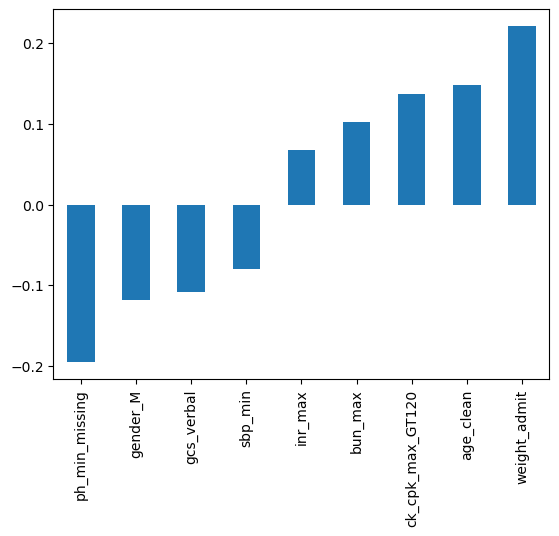

In [367]:
#Can put these lists in L2 and see if it performs any better
    #still terrible 

hp_ridge_alpha = 2

rc = RidgeClassifier(
    alpha = hp_ridge_alpha, #Alpha corresponds to 1 / (2C)
    fit_intercept = True,
    solver = "saga"    
    ).fit(x_train[backward_list], y_train)

#also returns mean accuracy
train_score_rc = rc.score(x_train[backward_list],y_train)
test_score_rc = rc.score(x_test[backward_list],y_test)

print(train_score_rc)
print(test_score_rc)

print(f"""number of features GE 0.001: {(abs(rc.coef_) >=0.001).sum()}""")
pd.Series(rc.coef_[0], x_train[backward_list].columns).sort_values(ascending = True).plot(kind = "bar")

 


#### Tree Feature Selection ####

In [368]:
#it is common to use a tree itself for feature selection
    #https://scikit-learn.org/stable/modules/feature_selection.html
    
#daniel uses base decision tree: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree

#if time: Could try to bring some of those back in - a couple of <40% filled? 


0.6486084614521378
0.5873265252683949
                    feature  importance
0                   bun_max    0.193402
24           ph_min_missing    0.153652
5              weight_admit    0.132316
15                  po2_min    0.112235
6                gcs_verbal    0.100100
1                 age_clean    0.078704
2                   sbp_min    0.048619
3                   inr_max    0.042668
16                   ph_min    0.037922
7                   dbp_min    0.025326
21             gcs_unable_1    0.024357
8                   ptt_max    0.014359
4           potassium_max.1    0.009016
9             glucose_max.2    0.006439
14                 spo2_min    0.004679
12             aniongap_max    0.004366
10           resp_rate_mean    0.003952
17                  ptt_min    0.003551
11         hemoglobin_min.1    0.002904
22          lactate_max_GT4    0.000552
13                  wbc_max    0.000434
23         ck_cpk_max_GT120    0.000289
18            calcium_min.1    0.000159
19

<Axes: xlabel='importance', ylabel='feature'>

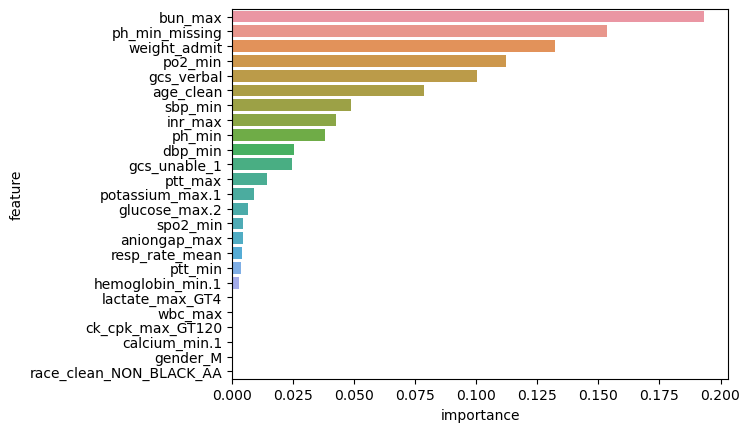

In [369]:
# Decision tree classifier in sklearn

#I'll try random forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 
#try max depth of 3 
clf = RFC(max_depth=3, random_state=0, criterion="entropy")
clf.fit(x_train, y_train)

#print(clf.get_params)
#print(clf.get_params(deep=True))
#print(clf.feature_importances_) #shown below

#also returns mean accuracy
train_score_rfc = clf.score(x_train,y_train)
test_score_rfc = clf.score(x_test,y_test)

print(train_score_rfc )
print(test_score_rfc)

data_tuples = list(zip(clf.feature_names_in_,clf.feature_importances_))
#print(data_tuples)

#convert to df 
fs_rf_varimport = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])

print(fs_rf_varimport.sort_values("importance", ascending=False))

#visualize
sns.barplot(data=fs_rf_varimport.sort_values("importance", ascending=False).head(50), x="importance", y="feature")


In [370]:
#Finalize forest type model fs:
    #try two lists - one with more features, one with less 

#natural break between 0.003 and 0.0006
rand_forest_more_list = ["bun_max", "ph_min_missing", "weight_admit", "po2_min", "gcs_verbal", "age_clean", "sbp_min", "inr_max", "ph_min", 
    "dbp_min", "gcs_unable_1", "ptt_max", "potassium_max.1", "glucose_max.2", "spo2_min", "aniongap_max", "resp_rate_mean", "ptt_min", 
    "hemoglobin_min.1"]

#natural break b/w 0.144 and 0.009
rand_forest_less_list = ["bun_max", "ph_min_missing", "weight_admit", "po2_min", "gcs_verbal", "age_clean", "sbp_min", "inr_max", "ph_min", 
    "dbp_min", "gcs_unable_1", "ptt_max"]


#### SVM Feature Selection ####

In [371]:
#forward and backward on SVM cannot run given my compute :(
    #idea: see if it can complete in 15 min if I use less of the data (starting at 5%) 
    #update: got up to 50%! 
    #note: if I stay with this sampling, consider stratified b/c data is getting small [it's ok b/c I'm at 50% now] 

size = 0.5

print(x_train.shape)
_05pct = round(x_train.shape[0]*size)
print(_05pct)

x_train05 = x_train.sample(_05pct)
y_train05 = y_train[x_train05.index]

print(x_train05.shape)
print(y_train05.shape)

(35644, 25)
17822
(17822, 25)
(17822,)


In [372]:
#What happens if I pair SFS with SVM instead of logistic regression: 
    #timing: still going at 15 min :/ 
    #5% sample with 1 feature is instant 
    #5% sample with auto and tol = 0.001 - couple seconds 
    #25% sample : still going at 140
        #try making tol larger change to 0.01 - keeps only gcs_verbal and finishes < 2 min 
        #back up to 0.005 - keeps only gcs_verbal as well
    #15% sample and back to 0.001: finishes under 2 min and get 9 - that's fine! 
    #50% sample, down to 3 cv, stil at 0.001 - 15 min woo! 

'''now turned off - no need to keep rerunning 

#from daniel with modifications
hp_svm_c = 2 #Regularization parameter. The strength of the regularization is inversely proportional to C. The penalty is a squared l2 penalty.
SVCModel = SVC(kernel='linear', C=hp_svm_c)

# Forward feature selection.
forward_selection = SFS(
    SVCModel
    , direction="forward"
    #, n_features_to_select = 1 #confirm it can complete if I just tell it to pick a single feature - confirmed, it finishes 
    , n_features_to_select="auto"
    , tol = 0.001   
    ,n_jobs=-1
    ,cv=3 #only try 3 b/c it's taking so long to run 
    ).fit(x_train05, y_train05)


print(forward_selection.get_feature_names_out())
'''

'''
['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'weight_admit' 'gcs_verbal'
 'dbp_min' 'po2_min' 'gender_M' 'gcs_unable_1' 'ph_min_missing']
'''

"\n['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'weight_admit' 'gcs_verbal'\n 'dbp_min' 'po2_min' 'gender_M' 'gcs_unable_1' 'ph_min_missing']\n"

In [373]:
# Backward feature selection

#5% takes a few seconds and returns more than forward 
#15% - 4ish min and returns fewer than recursive 
#50%, -0.001 and 3 cv - completed!! in 13 min 

'''now turned off - no need to keep rerunning 

backward_selection = SFS(
    SVCModel
    , direction="backward"
    #, n_features_to_select = 1
    , n_features_to_select="auto"
    , tol = -0.001   
    ,n_jobs=-1
    ,cv=3 #try 3 b/c it's taking so long to run 
    ).fit(x_train05, y_train05)

print(backward_selection.get_feature_names_out())

'''


'''
['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'potassium_max.1'
 'weight_admit' 'gcs_verbal' 'dbp_min' 'resp_rate_mean' 'aniongap_max'
 'spo2_min' 'ptt_min' 'calcium_min.1' 'gender_M' 'race_clean_NON_BLACK_AA'
 'gcs_unable_1' 'ck_cpk_max_GT120' 'ph_min_missing']
 '''

"\n['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'potassium_max.1'\n 'weight_admit' 'gcs_verbal' 'dbp_min' 'resp_rate_mean' 'aniongap_max'\n 'spo2_min' 'ptt_min' 'calcium_min.1' 'gender_M' 'race_clean_NON_BLACK_AA'\n 'gcs_unable_1' 'ck_cpk_max_GT120' 'ph_min_missing']\n "

In [374]:
#try recurive on full dataset
    #finished on the whole dataset in 12 min, yay! 
    #many more vars
    
'''now turned off - no need to keep rerunning 

selector = RFECV(
    estimator, 
    step=1, #just remove 1 feature each time, no need for more than that 
    cv=3, #cross validation. default is 5 with stratifiedkfold. Set to 3 b/c my computer is struggling to run :( 
    n_jobs = -1 
    )

selector = selector.fit(x_train, y_train)

print(selector.get_feature_names_out())
#print(selector.get_params())
print(selector.score(x_train, y_train))  #0.6664515767029514
print(selector.score(x_test, y_test))  #0.474993453783713
'''


'''
['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'potassium_max.1'
 'weight_admit' 'gcs_verbal' 'dbp_min' 'ptt_max' 'resp_rate_mean'
 'hemoglobin_min.1' 'aniongap_max' 'spo2_min' 'po2_min' 'ptt_min'
 'gender_M' 'race_clean_NON_BLACK_AA' 'gcs_unable_1' 'lactate_max_GT4'
 'ck_cpk_max_GT120' 'ph_min_missing']
 '''

"\n['bun_max' 'age_clean' 'sbp_min' 'inr_max' 'potassium_max.1'\n 'weight_admit' 'gcs_verbal' 'dbp_min' 'ptt_max' 'resp_rate_mean'\n 'hemoglobin_min.1' 'aniongap_max' 'spo2_min' 'po2_min' 'ptt_min'\n 'gender_M' 'race_clean_NON_BLACK_AA' 'gcs_unable_1' 'lactate_max_GT4'\n 'ck_cpk_max_GT120' 'ph_min_missing']\n "

In [375]:
#final lists

svm_forward_list = ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'weight_admit', 'gcs_verbal',
 'dbp_min', 'po2_min', 'gender_M', 'gcs_unable_1', 'ph_min_missing']

svm_backward_list = ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
 'weight_admit', 'gcs_verbal', 'dbp_min', 'resp_rate_mean', 'aniongap_max',
 'spo2_min', 'ptt_min', 'calcium_min.1', 'gender_M', 'race_clean_NON_BLACK_AA',
 'gcs_unable_1', 'ck_cpk_max_GT120', 'ph_min_missing']

svm_recursive_list = ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
 'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'resp_rate_mean',
 'hemoglobin_min.1', 'aniongap_max', 'spo2_min', 'po2_min', 'ptt_min',
 'gender_M', 'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'lactate_max_GT4',
 'ck_cpk_max_GT120', 'ph_min_missing']


### Model Training ###

In [376]:
#confirm and compare feature list

#full list after narrowing:
print(len(x_col_list))

#logistic backwards selection
print(len(backward_list), backward_list)

#random forest 
print(len(rand_forest_more_list), rand_forest_more_list)
print(len(rand_forest_less_list ), rand_forest_less_list )

#svm FS
print(len(svm_forward_list), svm_forward_list)
print(len(svm_backward_list), svm_backward_list)
print(len(svm_recursive_list), svm_recursive_list)


#Idea: use a dictionary change feature list per model based on my model-specific feature selection
feature_list_dict = {'RandomForest_more': rand_forest_more_list
                     , 'RandomForest_less': rand_forest_less_list                     
                     , 'XGBoost_more': rand_forest_more_list
                     , 'XGBoost_less': rand_forest_less_list                 
                     , 'Logistic_L1': backward_list
                     , 'Logistic_L2': backward_list
                     , 'SVM_rbf': svm_recursive_list
                     , 'SVM_linear': svm_recursive_list}                

25
9 ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'weight_admit', 'gcs_verbal', 'gender_M', 'ck_cpk_max_GT120', 'ph_min_missing']
19 ['bun_max', 'ph_min_missing', 'weight_admit', 'po2_min', 'gcs_verbal', 'age_clean', 'sbp_min', 'inr_max', 'ph_min', 'dbp_min', 'gcs_unable_1', 'ptt_max', 'potassium_max.1', 'glucose_max.2', 'spo2_min', 'aniongap_max', 'resp_rate_mean', 'ptt_min', 'hemoglobin_min.1']
12 ['bun_max', 'ph_min_missing', 'weight_admit', 'po2_min', 'gcs_verbal', 'age_clean', 'sbp_min', 'inr_max', 'ph_min', 'dbp_min', 'gcs_unable_1', 'ptt_max']
11 ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'weight_admit', 'gcs_verbal', 'dbp_min', 'po2_min', 'gender_M', 'gcs_unable_1', 'ph_min_missing']
18 ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'weight_admit', 'gcs_verbal', 'dbp_min', 'resp_rate_mean', 'aniongap_max', 'spo2_min', 'ptt_min', 'calcium_min.1', 'gender_M', 'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'ck_cpk_max_GT120', 'ph_min_missing']
21 ['bun_max', '

#### Grid Search ####

In [377]:
#prep gridsearch
    #retry with Halving to save time
    #takes about 13 min 
    #UPDATE: expand slightly for where grid search picked near the end of the initial range 

models_to_gs = {
    'Logistic_L1':LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True),
    #'Logistic_L2':RidgeClassifier(solver = "auto", fit_intercept = True),
    #'RandomForest_less':RFC(criterion='entropy'),    
    'XGBoost_more':XGBC(),  
    #'XGBoost_less':XGBC(),   
    #turn off - too much time to rerun 'SVM_rbf':SVC(kernel='rbf', probability=True), #finished in 3! why is this so much faster? I guess FS is running over and over 
    #'SVM_linear':SVC(kernel='linear', probability=True), #finished in 3! why is this so much faster? I guess FS is running over and over  
    'RandomForest_more':RFC(criterion='entropy'),
}

#not all models have the concept of feature importance, so need to skip those for FI saving syntax below 
fi_model_list = ['RandomForest_more', 'RandomForest_less', 'XGBoost_more', 'XGBoost_less']
coef_model_list = ['Logistic_L1', 'Logistic_L2']

stratifiedCV = StratifiedKFold(n_splits=8)


params = {
    'Logistic_L1':{
        'C':np.arange(start=0.001, stop=1, step=0.05) #20 values to test
    },
#    'Logistic_L2':{
#        'alpha':np.arange(start=0.5,stop=5.5) #11 values to test
#    },    
    'XGBoost_more':{
        'n_estimators':np.arange(start=2,stop=20,step=2),
        'max_depth':np.arange(start=2,stop=5),  #expanded after initial run; shrunk again
        'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
    },
#    'RandomForest_less':{
#        'max_depth':np.arange(start=1,stop=12) #expanded after initial run
#    },
#    'XGBoost_less':{
#        'n_estimators':np.arange(start=2,stop=20,step=2),
#        'max_depth':np.arange(start=2,stop=8), #expanded after initial run
#        'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
#    },
#    'SVM_rbf':{
#        'C':np.arange(0.5,5.5,step=1) #would be good to run more, but comp can't  handle it 
#    },
#    'SVM_linear':{
#        'C':np.arange(0.5,5.5,step=1) #would be good to run more, but comp can't  handle it 
#    }    
    'RandomForest_more':{
        'max_depth':np.arange(start=1,stop=10) #expanded after initial run; shrunk again
    }
}


#### Use custom feature lists per model ####

In [378]:
'''turn off: not showing superior performance
records = {}
gs_iter = {} #want to be able to see info on the grid search itself
feat_import = {} 
gs_best = {} 


for model in models_to_gs:
    
    print(model)
    
    BestParams = HalvingGridSearchCV(
        models_to_gs[model],
        param_grid = params[model],
        scoring='f1', #I have a balanced class, so accuracy isn't as bad, but f1 is still handy, so leave as is 
        cv=stratifiedCV,
        n_jobs=-1
    )
    
    
    #I added: call the feature list per model using my dictionary  
    BestParams.fit(x_train[feature_list_dict[model]],y_train)
    test[model] = BestParams.predict(x_test[feature_list_dict[model]]).astype(str)
    

    #print(BestParams.get_params(deep=True))
    #print(BestParams.get_params(deep=False))
    records[model] = BestParams

    #output of the iterations of grid search
    gs_iter[model] = pd.DataFrame(BestParams.cv_results_)
    
    print("grid search selected parameters: ",BestParams.best_params_)
    gs_best[model] = pd.DataFrame([BestParams.best_params_])

    
    #feature importance - not all models have this concept 
    if model in fi_model_list:
        feat_import[model] = BestParams.best_estimator_.feature_importances_
    
    
    #performance

    print('Training accuracy is: ',BestParams.score(x_train[feature_list_dict[model]], y_train))
    print('Testing accuracy is: ',BestParams.score(x_test[feature_list_dict[model]], y_test))
    print('For {} cross validation F1 score is {:.4f}'.format(model,BestParams.best_score_))
    
'''

'''
Logistic_L1
grid search selected parameters:  {'C': 0.30100000000000005}
Training accuracy is:  0.6308951061808599
Testing accuracy is:  0.6411969008816457
For Logistic_L1 cross validation F1 score is 0.6304
Logistic_L2
grid search selected parameters:  {'alpha': 3.5}
Training accuracy is:  0.6292562999385372
Testing accuracy is:  0.6412540078375489
For Logistic_L2 cross validation F1 score is 0.6292
RandomForest_more
grid search selected parameters:  {'max_depth': 8}
Training accuracy is:  0.6764442523234632
Testing accuracy is:  0.637929393852888
For RandomForest_more cross validation F1 score is 0.6351
RandomForest_less
grid search selected parameters:  {'max_depth': 8}
Training accuracy is:  0.6655973348962029
Testing accuracy is:  0.6426654326700602
For RandomForest_less cross validation F1 score is 0.6301
XGBoost_more
grid search selected parameters:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 16}
Training accuracy is:  0.6584369665935138
Testing accuracy is:  0.6377396569122099
For XGBoost_more cross validation F1 score is 0.6434
XGBoost_less
grid search selected parameters:  {'learning_rate': 0.35000000000000003, 'max_depth': 5, 'n_estimators': 10}
Training accuracy is:  0.6584226435834021
Testing accuracy is:  0.6356070027743231
For XGBoost_less cross validation F1 score is 0.6355
SVM_rbf
grid search selected parameters:  {'C': 0.5}
Training accuracy is:  0.666955660143671
Testing accuracy is:  0.6411670521259563
For SVM_rbf cross validation F1 score is 0.6415
SVM_linear
grid search selected parameters:  {'C': 4.5}
Training accuracy is:  0.6350911658174228
Testing accuracy is:  0.6408097456108921
For SVM_linear cross validation F1 score is 0.6339
'''

"\nLogistic_L1\ngrid search selected parameters:  {'C': 0.30100000000000005}\nTraining accuracy is:  0.6308951061808599\nTesting accuracy is:  0.6411969008816457\nFor Logistic_L1 cross validation F1 score is 0.6304\nLogistic_L2\ngrid search selected parameters:  {'alpha': 3.5}\nTraining accuracy is:  0.6292562999385372\nTesting accuracy is:  0.6412540078375489\nFor Logistic_L2 cross validation F1 score is 0.6292\nRandomForest_more\ngrid search selected parameters:  {'max_depth': 8}\nTraining accuracy is:  0.6764442523234632\nTesting accuracy is:  0.637929393852888\nFor RandomForest_more cross validation F1 score is 0.6351\nRandomForest_less\ngrid search selected parameters:  {'max_depth': 8}\nTraining accuracy is:  0.6655973348962029\nTesting accuracy is:  0.6426654326700602\nFor RandomForest_less cross validation F1 score is 0.6301\nXGBoost_more\ngrid search selected parameters:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 16}\nTraining accuracy is:  0.6584369665935138\nTes

#### Use same feature list per model ####

In [379]:
#Try using all base features - so all same features for each
    #rerun with updated grid search ranges in a couple spots 

records2 = {}
gs_iter2 = {} #want to be able to see info on the grid search itself
feat_import2 = {} 
gs_best2 = {} 
coefs2 = {} 
x_prob_train2 = {}
x_prob_test2 = {}
perm_import2 = {}


for model in models_to_gs:
    print(model)
        
    BestParams = HalvingGridSearchCV(
        models_to_gs[model],
        param_grid = params[model],
        scoring='f1', #f1 fine, accuracy would also work 
        cv=stratifiedCV,
        n_jobs=-1
    )
    
    
    #I added: call the feature list per model using my dictionary  
    BestParams.fit(x_train,y_train)
    test[model] = BestParams.predict(x_test).astype(str)
    

    #print(BestParams.get_params(deep=True))
    #print(BestParams.get_params(deep=False))
    records2[model] = BestParams
    
    

    #output of the iterations of grid search
    gs_iter2[model] = pd.DataFrame(BestParams.cv_results_)
    
    print("grid search selected parameters: ",BestParams.best_params_)

    gs_best2[model] = pd.DataFrame([BestParams.best_params_])

    
    #feature importance - not all models have this concept. otherwise grab coefficients
    if model in fi_model_list:
        feat_import2[model] = BestParams.best_estimator_.feature_importances_
        
    elif model in coef_model_list:
        coefs2[model] = BestParams.best_estimator_.coef_
        
    #can't complete elif model == "SVM_rbf":
        #perm_import2[model] = permutation_importance(BestParams, x_test, y_test)


    
    
    #performance
    print('Training accuracy is: ',BestParams.score(x_train, y_train))
    print('Testing accuracy is: ',BestParams.score(x_test, y_test))
    print('For {} cross validation F1 score is {:.4f}'.format(model,BestParams.best_score_))
    
    #get predicted probabilities for ensemble
    x_prob_train2[model] = pd.DataFrame(BestParams.predict_proba(x_train))
    x_prob_test2[model] = pd.DataFrame(BestParams.predict_proba(x_test))
    
    
#ponder: svm linear can't run anymore- is it the new prob predictions step or something I accidentially changed?  

Logistic_L1
grid search selected parameters:  {'C': 0.8510000000000001}
Training accuracy is:  0.6375668653522849
Testing accuracy is:  0.6410690423162584
For Logistic_L1 cross validation F1 score is 0.6370
XGBoost_more
grid search selected parameters:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 16}
Training accuracy is:  0.6553183658446816
Testing accuracy is:  0.6423141108844799
For XGBoost_more cross validation F1 score is 0.6395
RandomForest_more
grid search selected parameters:  {'max_depth': 9}
Training accuracy is:  0.7027610674070647
Testing accuracy is:  0.6419661143176317
For RandomForest_more cross validation F1 score is 0.6370


In [380]:
pd.DataFrame.from_dict(records2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\records2.csv", index=False)

pd.DataFrame.from_dict(feat_import2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\feat_import2.csv", index=False)

#these can't export as is 

#pd.DataFrame.from_dict(gs_iter2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\gs_iter2.csv", index=False)

#pd.DataFrame.from_dict(gs_best2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\gs_best2.csv", index=False)

#pd.DataFrame.from_dict(coefs2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\coefs2.csv", index=False)

#pd.DataFrame.from_dict(x_prob_train2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\x_prob_train2.csv", index=False)

#pd.DataFrame.from_dict(x_prob_test2, orient="index").to_csv(r"C:\Users\evalb\Box\Courses\SPH6004_AdvStats\MIMIC\x_prob_test2.csv", index=False)


In [381]:
'''most recent run:

Logistic_L1
grid search selected parameters:  {'C': 0.501}
Training accuracy is:  0.6374445972795354
Testing accuracy is:  0.6410690423162584
For Logistic_L1 cross validation F1 score is 0.6366
RandomForest_more
grid search selected parameters:  {'max_depth': 9}
Training accuracy is:  0.7010844378533692
Testing accuracy is:  0.6419222139117428
For RandomForest_more cross validation F1 score is 0.6376
XGBoost_more
grid search selected parameters:  {'learning_rate': 0.35000000000000003, 'max_depth': 4, 'n_estimators': 16}
Training accuracy is:  0.6670102155263876
Testing accuracy is:  0.641050210808739
For XGBoost_more cross validation F1 score is 0.6437
SVM_rbf
grid search selected parameters:  {'C': 0.5}
Training accuracy is:  0.6763383861868005
Testing accuracy is:  0.6411670521259563
For SVM_rbf cross validation F1 score is 0.6464


Logistic_L1
grid search selected parameters:  {'C': 0.901}
Training accuracy is:  0.6375252185608608
Testing accuracy is:  0.6410690423162584
For Logistic_L1 cross validation F1 score is 0.6368
RandomForest_more
grid search selected parameters:  {'max_depth': 11}
Training accuracy is:  0.7735976848716212
Testing accuracy is:  0.43370165745856354
For RandomForest_more cross validation F1 score is 0.6429
XGBoost_more
grid search selected parameters:  {'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 18}
Training accuracy is:  0.6989260360415024
Testing accuracy is:  0.07475209763539283
For XGBoost_more cross validation F1 score is 0.6492
SVM_rbf
grid search selected parameters:  {'C': 0.5}
Training accuracy is:  0.6763383861868005
Testing accuracy is:  0.6411670521259563
For SVM_rbf cross validation F1 score is 0.6462




'''

'''
Logistic_L1
grid search selected parameters:  {'C': 0.451}
Training accuracy is:  0.6375278906990249
Testing accuracy is:  0.6410690423162584
For Logistic_L1 cross validation F1 score is 0.6367
Logistic_L2
grid search selected parameters:  {'alpha': 1.5}
Training accuracy is:  0.6356332413370132
Testing accuracy is:  0.6411261582323592
For Logistic_L2 cross validation F1 score is 0.6347
RandomForest_more
grid search selected parameters:  {'max_depth': 9}
Training accuracy is:  0.7012198897764568
Testing accuracy is:  0.6397527163731734
For RandomForest_more cross validation F1 score is 0.6374
RandomForest_less
grid search selected parameters:  {'max_depth': 9}
Training accuracy is:  0.7014823965410747
Testing accuracy is:  0.6417897091722595
For RandomForest_less cross validation F1 score is 0.6378
XGBoost_more
grid search selected parameters:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 16}
Training accuracy is:  0.6811152976639036
Testing accuracy is:  0.6357227867801886
For XGBoost_more cross validation F1 score is 0.6449
XGBoost_less
grid search selected parameters:  {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 14}
Training accuracy is:  0.656612102262277
Testing accuracy is:  0.6391419893697798
For XGBoost_less cross validation F1 score is 0.6408
SVM_rbf
grid search selected parameters:  {'C': 0.5}
Training accuracy is:  0.6763383861868005
Testing accuracy is:  0.6411670521259563
For SVM_rbf cross validation F1 score is 0.6463
SVM_linear
grid search selected parameters:  {'C': 4.5}
Training accuracy is:  0.6360486862678971
Testing accuracy is:  0.6415498616194982
For SVM_linear cross validation F1 score is 0.6361
'''


'''expanded GS
Logistic_L1
grid search selected parameters:  {'C': 0.9510000000000001}
Training accuracy is:  0.6375668653522849
Testing accuracy is:  0.6410690423162584
For Logistic_L1 cross validation F1 score is 0.6370
Logistic_L2
grid search selected parameters:  {'alpha': 3.5}
Training accuracy is:  0.6356945722171113
Testing accuracy is:  0.6411261582323592
For Logistic_L2 cross validation F1 score is 0.6348
RandomForest_more
grid search selected parameters:  {'max_depth': 11}
Training accuracy is:  0.7748185508672654
Testing accuracy is:  0.6373232799245995
For RandomForest_more cross validation F1 score is 0.6434
RandomForest_less
grid search selected parameters:  {'max_depth': 10}
Training accuracy is:  0.7330049261083744
Testing accuracy is:  0.6410645708671966
For RandomForest_less cross validation F1 score is 0.6423
XGBoost_more
grid search selected parameters:  {'learning_rate': 0.15000000000000002, 'max_depth': 5, 'n_estimators': 18}
Training accuracy is:  0.6651171325463331
Testing accuracy is:  0.6155528554070474
For XGBoost_more cross validation F1 score is 0.6411
XGBoost_less
grid search selected parameters:  {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 18}
Training accuracy is:  0.6622310392186784
Testing accuracy is:  0.6398865784499055
For XGBoost_less cross validation F1 score is 0.6443
SVM_rbf
grid search selected parameters:  {'C': 0.5}
Training accuracy is:  0.6763383861868005
Testing accuracy is:  0.6411670521259563
For SVM_rbf cross validation F1 score is 0.6463
SVM_linear
grid search selected parameters:  {'C': 3.5}
Training accuracy is:  0.6360096876053833
Testing accuracy is:  0.6415498616194982
For SVM_linear cross validation F1 score is 0.6360
'''

"expanded GS\nLogistic_L1\ngrid search selected parameters:  {'C': 0.9510000000000001}\nTraining accuracy is:  0.6375668653522849\nTesting accuracy is:  0.6410690423162584\nFor Logistic_L1 cross validation F1 score is 0.6370\nLogistic_L2\ngrid search selected parameters:  {'alpha': 3.5}\nTraining accuracy is:  0.6356945722171113\nTesting accuracy is:  0.6411261582323592\nFor Logistic_L2 cross validation F1 score is 0.6348\nRandomForest_more\ngrid search selected parameters:  {'max_depth': 11}\nTraining accuracy is:  0.7748185508672654\nTesting accuracy is:  0.6373232799245995\nFor RandomForest_more cross validation F1 score is 0.6434\nRandomForest_less\ngrid search selected parameters:  {'max_depth': 10}\nTraining accuracy is:  0.7330049261083744\nTesting accuracy is:  0.6410645708671966\nFor RandomForest_less cross validation F1 score is 0.6423\nXGBoost_more\ngrid search selected parameters:  {'learning_rate': 0.15000000000000002, 'max_depth': 5, 'n_estimators': 18}\nTraining accuracy

In [382]:
#decision: use ALL shortlisted features (25) rather than my differing lists per model
    #performance using all shortlisted features was equal to or slightly better for every model!


In [383]:
#done: if any of the gs selected parameters are near the edge of the gs range, consider expanding
    #expanded - see notes 
    #didn't make a notable difference
    

#### Review grid search results ####

In [384]:
# https://scikit-learn.org/stable/modules/grid_search.html#grid-search
#can subset to best rank test score; look at a couple
print(gs_iter2['XGBoost_more'])

     iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0       0          440       0.005336      0.000683         0.002891   
1       0          440       0.005754      0.000790         0.002448   
2       0          440       0.005523      0.000667         0.002316   
3       0          440       0.005300      0.000470         0.001961   
4       0          440       0.005467      0.000588         0.001689   
..    ...          ...            ...           ...              ...   
278     3        11880       0.176265      0.014174         0.005216   
279     3        11880       0.142448      0.008461         0.004129   
280     4        35640       0.505047      0.008222         0.010297   
281     4        35640       0.433396      0.005710         0.010760   
282     4        35640       0.264999      0.006652         0.008633   

     std_score_time param_learning_rate param_max_depth param_n_estimators  \
0          0.000803                0.05               2  

#### Coefficients / Feature Importances #####

In [385]:
#review feature importances
#print(feat_import2['RandomForest_more'])

#convert to df and show most to least important 
data_tuples = list(zip(x_train.columns,feat_import2['RandomForest_more']))
feat_import_df = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])
print(feat_import_df.sort_values("importance", ascending=False))



                    feature  importance
5              weight_admit    0.140344
0                   bun_max    0.118619
1                 age_clean    0.087074
6                gcs_verbal    0.064773
2                   sbp_min    0.056960
15                  po2_min    0.053632
24           ph_min_missing    0.048244
7                   dbp_min    0.041600
8                   ptt_max    0.038651
10           resp_rate_mean    0.035813
9             glucose_max.2    0.035171
3                   inr_max    0.033896
14                 spo2_min    0.033388
17                  ptt_min    0.033201
16                   ph_min    0.032167
11         hemoglobin_min.1    0.029015
4           potassium_max.1    0.025529
13                  wbc_max    0.025462
18            calcium_min.1    0.022189
12             aniongap_max    0.022029
21             gcs_unable_1    0.010340
23         ck_cpk_max_GT120    0.004693
19                 gender_M    0.003768
20  race_clean_NON_BLACK_AA    0.001757


In [386]:
#print(feat_import2['XGBoost_more'])

#convert to df and show most to least important 
data_tuples = list(zip(x_train.columns,feat_import2['XGBoost_more']))
feat_import_df = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])
print(feat_import_df.sort_values("importance", ascending=False))


                    feature  importance
24           ph_min_missing    0.245558
0                   bun_max    0.169443
6                gcs_verbal    0.063934
14                 spo2_min    0.051684
5              weight_admit    0.045849
15                  po2_min    0.042168
1                 age_clean    0.040914
3                   inr_max    0.038995
2                   sbp_min    0.033600
7                   dbp_min    0.029512
10           resp_rate_mean    0.028828
8                   ptt_max    0.026755
9             glucose_max.2    0.024479
12             aniongap_max    0.023828
17                  ptt_min    0.021670
16                   ph_min    0.019188
23         ck_cpk_max_GT120    0.017468
18            calcium_min.1    0.017446
4           potassium_max.1    0.015565
11         hemoglobin_min.1    0.014142
21             gcs_unable_1    0.013709
19                 gender_M    0.009664
13                  wbc_max    0.005600
20  race_clean_NON_BLACK_AA    0.000000


weight_admit               0.533094
age_clean                  0.333451
ck_cpk_max_GT120           0.244369
bun_max                    0.140542
aniongap_max               0.113022
inr_max                    0.089010
ptt_max                    0.085838
ptt_min                    0.083548
resp_rate_mean             0.081243
potassium_max.1            0.065827
wbc_max                    0.029831
glucose_max.2              0.025580
ph_min                     0.009575
po2_min                   -0.042979
dbp_min                   -0.055025
calcium_min.1             -0.065606
hemoglobin_min.1          -0.075836
race_clean_NON_BLACK_AA   -0.083277
spo2_min                  -0.098775
sbp_min                   -0.122852
lactate_max_GT4           -0.125671
gcs_unable_1              -0.189326
gender_M                  -0.235198
ph_min_missing            -0.339241
gcs_verbal                -0.340330
dtype: float64

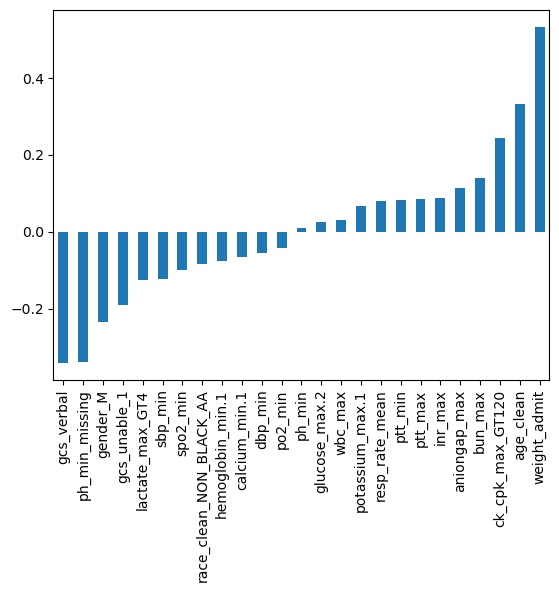

In [387]:
#coef review for log l1 , l2 

#print(coefs2['Logistic_L1'])

pd.Series(coefs2['Logistic_L1'][0],  x_train.columns).sort_values(ascending = True).plot(kind = "bar")

pd.Series(coefs2['Logistic_L1'][0],  x_train.columns).sort_values(ascending = False)

In [388]:
#to do: add RBF permutation importance
    #https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

'''couldn't complete
print(perm_importance)

#feature_names = ['feature1', 'feature2', 'feature3', ...... ]
#features = np.array(feature_names)

#sorted_idx = perm_importance.importances_mean.argsort()

plt.barh( x_train[feature_list_dict['SVM_rbf']], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
'''


'couldn\'t complete\nprint(perm_importance)\n\n#feature_names = [\'feature1\', \'feature2\', \'feature3\', ...... ]\n#features = np.array(feature_names)\n\n#sorted_idx = perm_importance.importances_mean.argsort()\n\nplt.barh( x_train[feature_list_dict[\'SVM_rbf\']], perm_importance.importances_mean[sorted_idx])\nplt.xlabel("Permutation Importance")\n'

In [389]:
#to do: turn on if running again pd.Series(coefs2['Logistic_L2'][0], x_train.columns).sort_values(ascending = True).plot(kind = "bar")



### Ensemble ###

In [390]:
#Since I'm using the same features for each model, I can use sklearn's out of the box ensemble
    #it doesn't work if you have diff features unless you use a Pipeline, which I couldn't quite code correctly 
    #but I'm having issues executing, so do it manually 

#### Calc accuracy of ensemble on training data ####

In [391]:
#get predictions together for ensemble: 
#print(x_prob_train2)

#print(x_prob_train2["Logistic_L1"])
print(x_prob_train2["Logistic_L1"][1]) #probability of aki_severe 


0        0.091364
1        0.399943
2        0.584371
3        0.159805
4        0.194617
           ...   
35639    0.635420
35640    0.106726
35641    0.454565
35642    0.627980
35643    0.443485
Name: 1, Length: 35644, dtype: float64


In [392]:
#combine

check = pd.DataFrame(x_prob_train2["Logistic_L1"][1])
#print(check)
check2 = check.rename(columns={1: "logistic_l1_prob1"})
#print(check2)

checka = pd.DataFrame(x_prob_train2["RandomForest_more"][1])
checka2 = checka.rename(columns={1: "rf_prob1"})

checkb = pd.DataFrame(x_prob_train2["XGBoost_more"][1])
checkb2 = checkb.rename(columns={1: "xgb_prob1"})

checkc = pd.DataFrame(x_prob_train2["SVM_rbf"][1])
checkc2 = checkc.rename(columns={1: "svm_rbf_prob1"})

#checkd = pd.DataFrame(x_prob_train2["SVM_linear"][1])
#checkd2 = checkd.rename(columns={1: "svm_lin_prob1"})



x_prob_train_concat = pd.concat([check2,checka2,checkb2,checkc2],axis=1) #,checkd2
print(x_prob_train_concat)

#should be similar - let's see 
sns.heatmap(x_prob_train_concat.corr(), annot=True)

KeyError: 'SVM_rbf'

In [ ]:
#try to just grab the x predictions
#I want the probability predictions, not the class predictions

print(x_prob_train_concat)

In [ ]:
#Calc weights
    #take logistic out 
f1_list = [0,0.6376, 0.6437,0] #these are all so close, it won't really impact the result much
f1_total = sum(f1_list)

f1_weights_list = []
for v in f1_list:
    print(v/f1_total)
    f1_weights_list.append(v/f1_total)

print(f1_weights_list)

x_prob_train_concat["logistic_l1_f1_wgt"] = f1_weights_list[0]
x_prob_train_concat["rf_f1_wgt"] = f1_weights_list[1]
x_prob_train_concat["xgb_f1_wgt"] = f1_weights_list[2]
x_prob_train_concat["svm_rbf_f1_wgt"] = f1_weights_list[3]
#x_prob_train_concat["svm_lin_f1_wgt"] = f1_weights_list[4]


print(x_prob_train_concat.head())


In [ ]:
#create soft voting result
x_prob_train_concat["soft_voting_prob1"] = \
    x_prob_train_concat["logistic_l1_f1_wgt"]*x_prob_train_concat["logistic_l1_prob1"] \
    + x_prob_train_concat["rf_f1_wgt"]*x_prob_train_concat["rf_prob1"] \
    + x_prob_train_concat["xgb_f1_wgt"]*x_prob_train_concat["xgb_prob1"] \
    + x_prob_train_concat["svm_rbf_f1_wgt"]*x_prob_train_concat["svm_rbf_prob1"] \
#    + x_prob_train_concat["svm_lin_f1_wgt"]*x_prob_train_concat["svm_lin_prob1"] \


x_prob_train_concat["soft_voting_predict"] = [1 if x >= 0.5 else 0 for x in x_prob_train_concat["soft_voting_prob1"]]

print(x_prob_train_concat.head(25))

#good print(0.091365*0.331787 +  0.187965* 0.332152 +   0.171375*0.33606  )

In [ ]:
#add on actual Y's

#print(x_prob_train_concat.shape) #35,664
#print(y_train.shape)
#print(x_train.shape)

x_prob_train_concat2 = pd.concat([x_prob_train_concat.reset_index(drop=True), y_train.reset_index(drop=True)],axis=1)

print(x_prob_train_concat2.shape) #why did obs grow? index issues: #https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows

In [ ]:
#now: apply the threhsold and compare to corresponding y 
print(x_prob_train_concat2.head())

#woo!
#crosstab & accuracy
print(pd.crosstab(x_prob_train_concat2["soft_voting_predict"],x_prob_train_concat2["aki_severe"]))

#to do: redo after fixing weights and such
print("accuracy: ",(14267        + 11312) /35644)
print("accuracy: ",(14523           + 11474) /35644)
print("accuracy: ",(14523           + 11474) /35644)
print("accuracy: ",(14117                 + 11192) /35644)

In [ ]:
#train data has mix but test data is all ones? 
print(x_prob_test2["Logistic_L1"][1].value_counts())

print(x_prob_test2["Logistic_L1"][1].describe())

In [ ]:
#train data has mix but test data is all ones? 
print(x_prob_test2["SVM_rbf"][1].value_counts())

print(x_prob_test2["SVM_rbf"][1].describe())

#### Calc accuracy of ensemble on test data ####

In [ ]:
#combine
check = pd.DataFrame(x_prob_test2["Logistic_L1"][1])
#print(check)
check2 = check.rename(columns={1: "logistic_l1_prob1"})
#print(check2)

checka = pd.DataFrame(x_prob_test2["RandomForest_more"][1])
checka2 = checka.rename(columns={1: "rf_prob1"})

checkb = pd.DataFrame(x_prob_test2["XGBoost_more"][1])
checkb2 = checkb.rename(columns={1: "xgb_prob1"})

checkc = pd.DataFrame(x_prob_test2["SVM_rbf"][1])
checkc2 = checkc.rename(columns={1: "svm_rbf_prob1"})

#checkd = pd.DataFrame(x_prob_test2["SVM_linear"][1])
#checkd2 = checkd.rename(columns={1: "svm_lin_prob1"})



x_prob_test_concat = pd.concat([check2,checka2,checkb2,checkc2],axis=1) #,checkd2
print(x_prob_test_concat)




x_prob_test_concat["logistic_l1_f1_wgt"] = f1_weights_list[0]
x_prob_test_concat["rf_f1_wgt"] = f1_weights_list[1]
x_prob_test_concat["xgb_f1_wgt"] = f1_weights_list[2]
x_prob_test_concat["svm_rbf_f1_wgt"] = f1_weights_list[3]
#x_prob_test_concat["svm_lin_f1_wgt"] = f1_weights_list[4]


print(x_prob_test_concat.head())

#create soft voting result
x_prob_test_concat["soft_voting_prob1"] = \
    x_prob_test_concat["logistic_l1_f1_wgt"]*x_prob_test_concat["logistic_l1_prob1"] \
    + x_prob_test_concat["rf_f1_wgt"]*x_prob_test_concat["rf_prob1"] \
    + x_prob_test_concat["xgb_f1_wgt"]*x_prob_test_concat["xgb_prob1"] \
    + x_prob_test_concat["svm_rbf_f1_wgt"]*x_prob_test_concat["svm_rbf_prob1"] \
#    + x_prob_test_concat["svm_lin_f1_wgt"]*x_prob_test_concat["svm_lin_prob1"] \


x_prob_test_concat["soft_voting_predict"] = [1 if x >= 0.5 else 0 for x in x_prob_test_concat["soft_voting_prob1"]]

print(x_prob_test_concat.head())


#add on actual Y's

#print(x_prob_test_concat.shape) #35,664
#print(y_test.shape)
#print(x_test.shape)

x_prob_test_concat2 = pd.concat([x_prob_test_concat.reset_index(drop=True), y_test.reset_index(drop=True)],axis=1)


print(x_prob_test_concat2.shape) #why did obs grow? index issues: #https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows


#now: apply the threhsold and compare to corresponding y 
print(x_prob_test_concat2.head())



In [ ]:
#should be similar - let's see 

temp = x_prob_test_concat[["rf_prob1","xgb_prob1"]]

print(temp.head())
sns.heatmap(temp.corr(), annot=True)

In [ ]:

#crosstab & accuracy
print(pd.crosstab(x_prob_test_concat2["soft_voting_predict"],x_prob_test_concat2["aki_severe"]))

#to do: redo after fixing weights and such
print("accuracy: ",(11          + 3598) /7638 )
print("accuracy: ",(332             + 3461) /7638 )
print("accuracy: ",(466                   + 3386) /7638 )

In [ ]:
#to ponder: how can test accuracy be 4966 if inidivudal models aren't that bad?
    #keep googling to get more info https://stats.stackexchange.com/questions/208736/ensemble-models-perform-worse-than-single-one 

#to do: consider switching ridge to l2 peanlty on logistic

### Final test on 'external' validation data! ###

In [393]:
print(y_validate.shape)
print(x_validate.shape)
print(x_validate.head())

(7638,)
(7638, 90)
             id     race  heart_rate_min  heart_rate_max  heart_rate_mean  \
6455   32407635    WHITE            72.0           116.0        94.650000   
22497  38072380    WHITE            68.0            90.0        79.409091   
39476  31014237  UNKNOWN            60.0            89.0        69.666667   
46969  32018850    WHITE            58.0            72.0        65.631579   
33165  33956506    WHITE            37.0           176.0        88.411765   

       sbp_min  sbp_max    sbp_mean  dbp_min  dbp_max  ...  weight_admit  \
6455      98.5    153.0  129.456522     56.0     78.0  ...          60.1   
22497     94.0    153.0  124.363636     32.0     56.0  ...          68.4   
39476     92.0    131.0  118.083333     49.0     77.0  ...          81.0   
46969     84.0    175.0  147.421053     47.0    120.0  ...          60.2   
33165     69.0    145.0   95.671429     33.0     70.0  ...          68.2   

       aki_severe_char  lactate_max_GT2  lactate_max_GT4  ck_

In [394]:
#subset to columns where available, then make the rest 

print(len(x_col_list))

x_validate_raw = x_validate[x_col_list]
print(x_validate_raw.shape)
print(x_validate_raw.head())

25
(7638, 25)
       bun_max  age_clean  sbp_min  inr_max  potassium_max.1  weight_admit  \
6455      12.0  45.043308     98.5      1.3              4.3          60.1   
22497     28.0  78.032141     94.0      1.1              4.8          68.4   
39476     13.0  21.496205     92.0      1.3              NaN          81.0   
46969     28.0  85.612923     84.0      2.2              4.5          60.2   
33165     13.0  75.408160     69.0      NaN              3.7          68.2   

       gcs_verbal  dbp_min  ptt_max  glucose_max.2  ...  po2_min  ph_min  \
6455          0.0     56.0     28.7          117.0  ...    201.0    7.28   
22497         4.0     32.0     24.2          372.0  ...    130.0    7.39   
39476         5.0     49.0     27.7            NaN  ...      NaN     NaN   
46969         5.0     47.0     34.4           84.0  ...      NaN     NaN   
33165         5.0     33.0      NaN          117.0  ...    105.0    7.46   

       ptt_min  calcium_min.1  gender_M  race_clean_NON_BLAC

In [395]:
print(x_train_withoutliers.head())

             id                    race  heart_rate_min  heart_rate_max  \
12887  31783914                   WHITE            50.0            92.0   
15127  36125872  WHITE - OTHER EUROPEAN            64.0            87.0   
8644   32267488  BLACK/AFRICAN AMERICAN           108.0           133.0   
2290   38460352                   WHITE            72.0           112.0   
28408  39940480                   WHITE            59.0            96.0   

       heart_rate_mean  sbp_min  sbp_max    sbp_mean  dbp_min  dbp_max  ...  \
12887        63.142857     96.0    139.0  111.315789     57.0     84.0  ...   
15127        77.900000     98.0    153.0  127.433333     46.0     89.0  ...   
8644        121.040000    111.0    185.0  146.958333     79.0    109.0  ...   
2290         90.260870    138.0    163.0  152.250000     76.0    109.0  ...   
28408        81.925926     99.0    140.0  130.111111     55.0     88.0  ...   

       weight_admit  aki_severe_char  lactate_max_GT2  lactate_max_GT4  \


In [396]:
#apply the TRAINING values for outlier removal
print(x_validate_raw.shape)  

#luckily I left them in here: x_train_withoutliers
x_validate_withoutliers = x_validate

#these are clinically bound and are already clean
do_outlier_removal_list_validate = ['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
       'weight_admit', 'dbp_min', 'ptt_max', 'glucose_max.2',
       'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max',
       'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1']

#either: lit_col_num, num_cols_list
for c in do_outlier_removal_list_validate:
                    
    #start = x_train.shape[0]
    print(f"""now processing {c}""")    
   
    upper = x_train_withoutliers[c].mean() + 3*x_train_withoutliers[c].std()
    lower = x_train_withoutliers[c].mean() - 3*x_train_withoutliers[c].std()  #may go negative - ok if I'm not setting to that value 

    #set to missing: (same as dropping but leaves in rows for other calcs)
    x_validate_raw[c] = [np.NAN if x < lower else np.NAN if x > upper else x for x in x_validate_raw[c]]     

#confirm no rows dropped
print(x_validate_raw.shape)  



(7638, 25)
now processing bun_max
now processing age_clean
now processing sbp_min
now processing inr_max
now processing potassium_max.1
now processing weight_admit
now processing dbp_min
now processing ptt_max
now processing glucose_max.2
now processing resp_rate_mean
now processing hemoglobin_min.1
now processing aniongap_max
now processing wbc_max
now processing spo2_min
now processing po2_min
now processing ph_min
now processing ptt_min
now processing calcium_min.1
(7638, 25)


C:\Users\evalb\AppData\Local\Temp\ipykernel_40584\1665894871.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_validate_raw[c] = [np.NAN if x < lower else np.NAN if x > upper else x for x in x_validate_raw[c]]


In [397]:
print(x_validate_raw.info(verbose=True))
print(x_validate_raw.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7638 entries, 6455 to 15958
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bun_max                  7222 non-null   float64
 1   age_clean                7638 non-null   float64
 2   sbp_min                  7520 non-null   float64
 3   inr_max                  6578 non-null   float64
 4   potassium_max.1          7295 non-null   float64
 5   weight_admit             7372 non-null   float64
 6   gcs_verbal               7559 non-null   float64
 7   dbp_min                  7555 non-null   float64
 8   ptt_max                  6343 non-null   float64
 9   glucose_max.2            7229 non-null   float64
 10  resp_rate_mean           7491 non-null   float64
 11  hemoglobin_min.1         7537 non-null   float64
 12  aniongap_max             7304 non-null   float64
 13  wbc_max                  7396 non-null   float64
 14  spo2_min            

In [398]:
print(x_num_norm.head())

       heart_rate_min  heart_rate_max  heart_rate_mean   sbp_min   sbp_max  \
12887       -1.355943       -0.512018        -1.368404  0.162749 -0.405776   
15127       -0.392156       -0.770307        -0.399636  0.284052  0.250336   
8644         2.636888        1.605952         2.432393  1.072524  1.750019   
2290         0.158579        0.521138         0.411823  2.710118  0.718987   
28408       -0.736366       -0.305387        -0.135344  0.344704 -0.358911   

       sbp_mean   dbp_min   dbp_max  dbp_mean   mbp_min  ...    pt_min  \
12887 -0.477568  0.868732 -0.202230  0.255909  0.592422  ... -0.936104   
15127  0.543629 -0.107936  0.076283 -0.013795 -0.459931  ... -0.597105   
8644   1.780720  2.822069  1.190336  2.585845  2.454276  ... -0.473833   
2290   2.115997  2.555705  1.190336  2.796048       NaN  ... -0.812832   
28408  0.713292  0.691156  0.020580  0.949658  0.835272  ... -0.812832   

         pt_max   ptt_min   ptt_max  gcs_min  gcs_motor  gcs_verbal  gcs_eyes  \
12887

In [399]:
do_outlier_removal_list_validate.append("gcs_verbal")



In [400]:
print(do_outlier_removal_list_validate)

['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1', 'weight_admit', 'dbp_min', 'ptt_max', 'glucose_max.2', 'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1', 'gcs_verbal']


In [401]:
#this is training data: 

x_num_subset = x_num[do_outlier_removal_list_validate]

print(x_num_subset.shape)

#same
#print(x_num_subset.columns)
#print(x_validate_normalized.columns)

(35644, 19)


In [402]:
#normalize 
x_validate_normalized = x_validate_raw[do_outlier_removal_list_validate]

x_validate_normalized = (x_validate_normalized-x_num_subset.mean())/x_num_subset.std()

#here we're NOT always at 0 and 1 b/c the training data isn't the same as test, like for INR_MAX
x_validate_normalized.describe()

,bun_max,age_clean,sbp_min,inr_max,potassium_max.1,weight_admit,dbp_min,ptt_max,glucose_max.2,resp_rate_mean,hemoglobin_min.1,aniongap_max,wbc_max,spo2_min,po2_min,ph_min,ptt_min,calcium_min.1,gcs_verbal
count,7222.000000,7638.000000,7520.000000,6578.000000,7295.000000,7372.000000,7555.000000,6343.000000,7229.000000,7491.000000,7537.000000,7304.000000,7396.000000,7333.000000,4449.000000,4547.000000,6570.000000,6819.000000,7559.000000
mean,-0.071379,0.026656,0.005890,-0.124804,-0.041964,-0.034343,0.016480,-0.124514,-0.073315,-0.002909,0.013340,-0.037362,-0.052856,0.074415,-0.081392,0.012644,-0.095621,0.008844,0.016492
std,0.847927,0.991320,0.981991,0.686666,0.925771,0.913654,1.005215,0.717052,0.835031,0.971423,0.996930,0.930431,0.898208,0.860294,0.883279,0.961245,0.795142,0.970150,0.990515
min,-1.374572,-2.722763,-2.991136,-1.501232,-2.926558,-2.487847,-2.949154,-1.102286,-1.897670,-2.635609,-2.967978,-2.421164,-2.030886,-2.885826,-1.538316,-2.970962,-1.832543,-2.971152,-1.615568
25%,-0.682057,-0.562481,-0.625722,-0.585637,-0.677609,-0.691551,-0.640665,-0.555382,-0.663691,-0.696461,-0.713319,-0.678691,-0.700536,-0.362437,-0.817573,-0.551086,-0.616842,-0.645372,-1.137789
50%,-0.304321,0.121087,-0.079857,-0.402517,-0.227819,-0.137806,-0.019148,-0.359649,-0.284005,-0.138914,-0.005975,-0.180842,-0.195920,0.142240,-0.233187,0.080186,-0.253529,0.000677,0.773329
75%,0.262283,0.805648,0.587311,0.146840,0.521830,0.532991,0.602368,0.014549,0.285524,0.560818,0.745578,0.565933,0.446318,0.646918,0.390158,0.606246,0.249520,0.646727,0.773329
max,2.969389,1.473957,2.952724,2.893628,2.920709,2.982075,2.999645,2.996612,2.990787,2.997744,2.956027,2.806256,2.984688,1.908612,2.980937,2.815699,2.988342,2.972506,0.773329


In [403]:
print(x_validate_normalized.columns)

Index(['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
       'weight_admit', 'dbp_min', 'ptt_max', 'glucose_max.2', 'resp_rate_mean',
       'hemoglobin_min.1', 'aniongap_max', 'wbc_max', 'spo2_min', 'po2_min',
       'ph_min', 'ptt_min', 'calcium_min.1', 'gcs_verbal'],
      dtype='object')


In [404]:
#mean imputation - apply the TRAINING mean

#need to refit on smaller training col list b.c now there are fewer cols
imp.fit(x_train_num[do_outlier_removal_list_validate])

SimpleImputer()

x_validate_imputed = imp.transform(x_validate_normalized)


In [405]:
print(x_validate_imputed.head)

<bound method NDFrame.head of             bun_max  age_clean   sbp_min       inr_max  potassium_max.1  \
6455  -7.450125e-01  -1.147994  0.314378 -2.193982e-01    -2.278192e-01   
22497  2.622827e-01   0.775971  0.041446 -5.856366e-01     5.218304e-01   
39476 -6.820566e-01  -2.521300 -0.079857 -2.193982e-01     4.206164e-16   
46969  2.622827e-01   1.218095 -0.565070  1.428674e+00     7.204063e-02   
33165 -6.820566e-01   0.622936 -1.474845  1.216000e-17    -1.127399e+00   
...             ...        ...       ...           ...              ...   
18752 -1.311616e+00  -1.078623  0.829917 -2.193982e-01    -9.774689e-01   
1548   4.265967e-17   0.323845 -0.686374 -2.193982e-01    -1.127399e+00   
17068 -1.784089e-01   1.098746 -0.383115 -5.856366e-01     1.121550e+00   
11753  7.029744e-01   0.584227 -2.445271  5.130784e-01     4.206164e-16   
15958  3.252387e-01   0.342416  0.526659 -7.687557e-01     5.218304e-01   

       weight_admit   dbp_min       ptt_max  glucose_max.2  resp_rate

In [406]:
#recombine with non numeric
add_back_in  = ['ck_cpk_max_GT120', 'gcs_unable_1', 'gender_M', 'lactate_max_GT4', 'ph_min_missing', 'race_clean_NON_BLACK_AA']


x_validate_prepped =  pd.concat([x_validate_imputed, x_validate_raw[add_back_in]] ,axis=1) 

print(x_validate_raw.shape)
print(x_validate_prepped.shape)

print(x_validate_prepped.head())


(7638, 25)
(7638, 25)
        bun_max  age_clean   sbp_min       inr_max  potassium_max.1  \
6455  -0.745013  -1.147994  0.314378 -2.193982e-01    -2.278192e-01   
22497  0.262283   0.775971  0.041446 -5.856366e-01     5.218304e-01   
39476 -0.682057  -2.521300 -0.079857 -2.193982e-01     4.206164e-16   
46969  0.262283   1.218095 -0.565070  1.428674e+00     7.204063e-02   
33165 -0.682057   0.622936 -1.474845  1.216000e-17    -1.127399e+00   

       weight_admit   dbp_min       ptt_max  glucose_max.2  resp_rate_mean  \
6455      -0.943663  0.779944 -4.690292e-01  -5.845896e-01       -0.613218   
22497     -0.569997 -1.350969 -7.280888e-01  -1.822007e-16        0.195116   
39476     -0.002746  0.158428 -5.265980e-01  -1.822007e-16       -1.395265   
46969     -0.939161 -0.019148 -1.408871e-01  -1.106658e+00       -0.573441   
33165     -0.579001 -1.262181  7.076722e-17  -5.845896e-01        0.918016   

       ...        ph_min       ptt_min  calcium_min.1  gcs_verbal  \
6455   ... -4

In [407]:
#get back into the same order as train

x_validate_prepped2 = x_validate_prepped[['bun_max', 'age_clean', 'sbp_min', 'inr_max', 'potassium_max.1',
       'weight_admit', 'gcs_verbal', 'dbp_min', 'ptt_max', 'glucose_max.2',
       'resp_rate_mean', 'hemoglobin_min.1', 'aniongap_max', 'wbc_max',
       'spo2_min', 'po2_min', 'ph_min', 'ptt_min', 'calcium_min.1', 'gender_M',
       'race_clean_NON_BLACK_AA', 'gcs_unable_1', 'lactate_max_GT4',
       'ck_cpk_max_GT120', 'ph_min_missing']]



#combine with y
validate_prepped =  pd.concat([x_validate_prepped2, y_validate] ,axis=1) 
print(validate_prepped.shape)

(7638, 26)


In [408]:
print(x_validate_prepped2.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7638 entries, 6455 to 15958
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bun_max                  7638 non-null   float64
 1   age_clean                7638 non-null   float64
 2   sbp_min                  7638 non-null   float64
 3   inr_max                  7638 non-null   float64
 4   potassium_max.1          7638 non-null   float64
 5   weight_admit             7638 non-null   float64
 6   gcs_verbal               7638 non-null   float64
 7   dbp_min                  7638 non-null   float64
 8   ptt_max                  7638 non-null   float64
 9   glucose_max.2            7638 non-null   float64
 10  resp_rate_mean           7638 non-null   float64
 11  hemoglobin_min.1         7638 non-null   float64
 12  aniongap_max             7638 non-null   float64
 13  wbc_max                  7638 non-null   float64
 14  spo2_min            

In [409]:
#to do: double check on gsc verbal - not normalized? 

In [410]:
#my final random forest is already stored in BestParams!

print(BestParams)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
                    estimator=RandomForestClassifier(criterion='entropy'),
                    n_jobs=-1,
                    param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                    scoring='f1')


In [416]:
#this is what went in: print(records2['RandomForest_more'])

#which were picked print(gs_best2['RandomForest_more'])

validate_score = BestParams.score(x_validate_prepped2, y_validate)
validate_feat_import = BestParams.best_estimator_.feature_importances_


print('accuracy', validate_score)
print('f1',BestParams.best_score_)



accuracy 0.6380759200231817
f1 0.6377307396511012


In [440]:
#get predicted probabilities
x_prob_validate = pd.DataFrame(BestParams.predict_proba(x_validate_prepped2))

print(x_prob_validate.head())

          0         1
0  0.743896  0.256104
1  0.461234  0.538766
2  0.823594  0.176406
3  0.617482  0.382518
4  0.553094  0.446906


In [443]:
y_validate_predict = BestParams.predict(x_validate_prepped2)

print(y_validate_predict)

[0 1 0 ... 0 1 0]


In [447]:
#actual result vs predicted class
pd.crosstab(y_validate,y_validate_predict)



col_0,0,1
aki_severe,,
0,2938,1022
1,1476,2202


In [426]:
#from daniel
from sklearn.metrics import roc_curve, precision_recall_curve

# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

y_pred = x_prob_validate #predicted probabilities I'm already calcing. code subsets to only probability for 1 below 
y_df_test = y_validate

yroc = np.array([1, 1, 2, 2])

fpr, tpr, _  = roc_curve(y_df_test,y_pred.iloc[:,1].values)


roc_df = pd.DataFrame(
    {
        'False Positive Rate':fpr,
        'True Positive Rate':tpr

    }
)

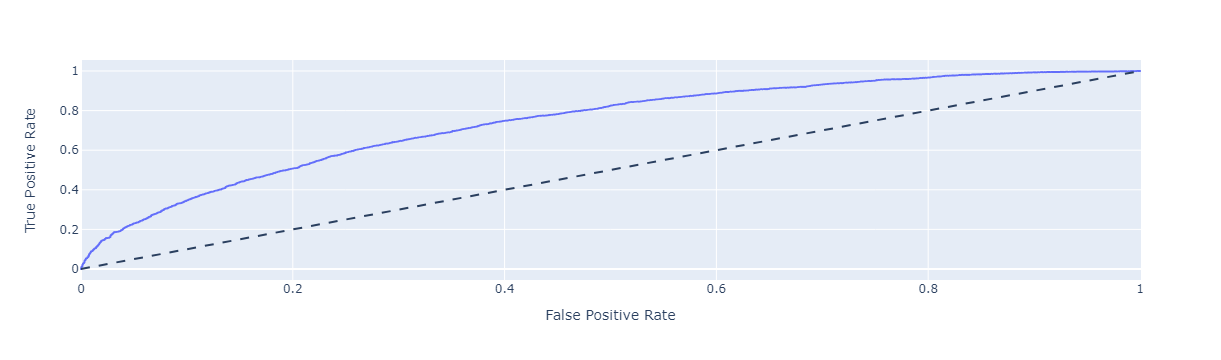

In [436]:
# Visualize ROC curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate') #facet_col='method',color='method'

#I added the line for random guess 
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1,
             line_dash='dash')

fig

In [430]:
# precision recall curves
p_, r_, _ = precision_recall_curve(y_df_test,y_pred.iloc[:,1].values)


pr_df = pd.DataFrame(
    {
        'Precision': p_,
        'Recall':r_,
    }
)

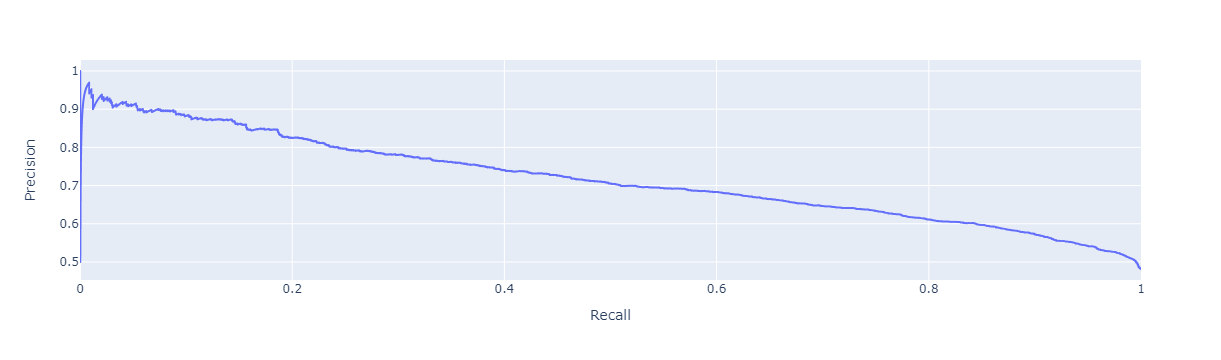

In [434]:
# Visualize precision recall curve
fig = px.line(pr_df,x='Recall',y='Precision') #,facet_col='method',color='method'
fig


### Storage ###